In [1]:
import os 
import joblib
import pickle 

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb
import catboost as cb

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# metrics 
from sklearn.metrics import brier_score_loss, confusion_matrix
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

%matplotlib inline

import random 
random.seed(42)

import warnings
warnings.filterwarnings('ignore')



In [2]:
""" 
NOTE: Right now the data is minmax scaled; However, I will be changing it to standard scaling and compare the performance of the models. 
"""


' \nNOTE: Right now the data is minmax scaled; However, I will be changing it to standard scaling and compare the performance of the models. \n'

In [3]:
""" 
Helper functions 
"""

def custom_brier_score(Y,y):
    return np.mean((Y - y) ** 2)

brier_score_loss = make_scorer(custom_brier_score, greater_is_better=False)

In [4]:
# Load the data 
train_data = pd.read_csv('../data/Recvidism_extra_feat_train.csv')
test_data = pd.read_csv('../data/Recvidism_extra_feat_test.csv')

# length of train and test data  
print("Length of train data: ", len(train_data))
print("Length of test data: ", len(test_data))
print(train_data.columns)

# features and labels 
X_train = train_data.drop(['Recidivism_Within_3years'], axis=1)
#X_train = np.ascontiguousarray(X_train)  # only for kNN
y_train = train_data['Recidivism_Within_3years']
X_test = test_data.drop(['Recidivism_Within_3years'], axis=1)
y_test = test_data['Recidivism_Within_3years']

Length of train data:  18028
Length of test data:  7807
Index(['Gender', 'Race', 'Age_at_Release', 'Residence_PUMA', 'Gang_Affiliated',
       'Supervision_Risk_Score_First', 'Supervision_Level_First',
       'Education_Level', 'Dependents', 'Prison_Offense', 'Prison_Years',
       'Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd',
       'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property',
       'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probat

In [5]:
# Split the data into train and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Pipeline; useful if preprocessing is required 
pipeline = Pipeline(steps=[('model', None)])


In [6]:
# All possible models to run 

# Create a dictionary of classifiers and their hyperparameters
classifiers = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__penalty': ['l1', 'l2'],
            'model__solver': ['liblinear']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2, 4]
        }
    },
    
    'XGBoost': {
        'model': xgb.XGBClassifier(),
        'params': {
            'model__n_estimators': [50, 100, 200,500,800],
            'model__max_depth': [3, 4, 5,6,7],
            'model__learning_rate': [0.01, 0.1, 0.3]
        }
    },
    'CatBoost': {
        'model': cb.CatBoostClassifier(verbose=0),
        'params': {
            'model__iterations': [100, 200, 300,500, 800],
            'model__learning_rate': [0.01, 0.1, 0.3],
            'model__max_depth': [3, 4, 5,6,7]
        }
    },
    'SVM': { 
        'model': SVC(probability=True),  # Added SVM with probability=True to calculate AUC
        'params': {
            'model__C': np.linspace(0.01,10,20),
            'model__kernel': ['linear', 'rbf']
        }
    },
    
    'KNN': {    
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': np.linspace(5,50,10).astype(int),
            'model__weights': ['uniform', 'distance'],
            'model__metric': ['euclidean', 'manhattan']
        }
    }
}

In [51]:

# Train and evaluate classifiers in parallel using Joblib
def train_and_evaluate_classifier(classifier_name, classifier_info):
    print(f"Training {classifier_name}...")
    
    # Create a pipeline with standard scaling and the classifier
    clf = Pipeline([
        ('model', classifier_info['model'])
    ])
    
    # Perform a grid search for hyperparameter tuning
    param_grid = classifier_info['params']

    
    # Use custom scoring functions
    grid_search = GridSearchCV(
        clf, param_grid, cv=5,
        scoring='neg_brier_score',  # Use Brier score as the metric
        refit='AUC',  # Refit using AUC as the best estimator
        verbose=2
    )
    
    grid_search.fit(X_train, y_train)

    # Calculate ROC AUC for the best classifier
    y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    return {
        'classifier_name': classifier_name,
        'Best Model': grid_search.best_estimator_,
        'Best Parameters': grid_search.best_params_,
        'Brier Score': -grid_search.best_score_,  # Convert back to positive
        'AUC': auc
    }


In [ ]:

# Train and evaluate classifiers in parallel
results = Parallel(n_jobs=10)(
    delayed(train_and_evaluate_classifier)(classifier_name, classifier_info)
    for classifier_name, classifier_info in classifiers.items()
)

# Compare classifier results
for result in results:
    classifier_name = result['classifier_name']
    print(f"\nResults for {classifier_name}:")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Brier Score: {result['Brier Score']:.4f}")
    print(f"AUC: {result['AUC']:.4f}\n")

# save all the models 
for result in results:
    classifier_name = result['classifier_name']
    best_classifier = result['Best Model']
    # also save best_params 
    best_params = result['Best Parameters']
    # save the model
    joblib.dump(best_classifier, f'./trained_models/{classifier_name}.pkl')
    # save the best params
    joblib.dump(best_params, f'./trained_models/{classifier_name}_best_params.pkl')
    
    

# Choose the best classifier based on AUC
best_result = max(results, key=lambda x: x['AUC'])
best_classifier_name = best_result['classifier_name']
best_classifier = best_result['Best Model']

# Evaluate the best classifier on the test set
y_pred_prob = best_classifier.predict_proba(X_test)[:, 1]
test_brier_score = custom_brier_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
test_auc = auc(fpr, tpr)


print(f"Best Classifier: {best_classifier_name}")
print(f"Test Brier Score: {test_brier_score:.4f}")
print(f"Test AUC: {test_auc:.4f}")


# Test and compare the models 

In [71]:
# Load saved sklearn model 
classifier_names = list(classifiers.keys())
print(classifier_names)

['Logistic Regression', 'Random Forest', 'XGBoost', 'CatBoost', 'SVM', 'KNN', 'bayesian_classifier']


In [92]:
model_dict = {}
for i in classifier_names:
    try:
        clf = joblib.load(f'./trained_models/{i}.pkl')
        print(f"Loaded {i} model")
    except:
        print(f"Could not load {i} model! Trying with pickle...")
        try:
            clf = pickle.load(open(f'./trained_models/{i}.pkl', 'rb'))
            print(f"Loaded {i} model")
        except:
            print(f"Could not load {i} model, even with pickle!.. Skipping....")
        
    #print(clf)
    model_dict[i] = clf


Loaded Logistic Regression model
Could not load Random Forest model! Trying with pickle...
Loaded Random Forest model
Loaded XGBoost model
Loaded CatBoost model
Loaded SVM model
Loaded KNN model
Loaded bayesian_classifier model


Total count female:  950
Total count male:  6857
---------------------------------------------------------Predictions for  Model: Logistic Regression ---------------------------------------------------------
---------------------------------------------------------Predictions for complete test set: 
Test Brier Score Logistic Regression: 0.1862


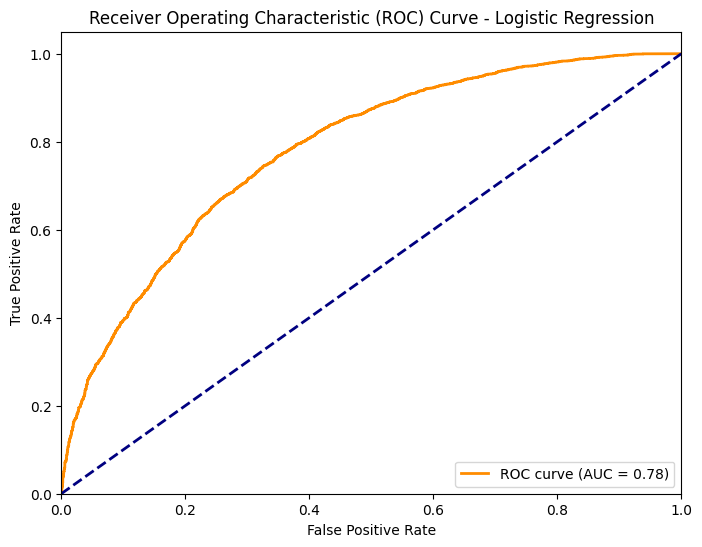

AUC - Logistic Regression: 0.78
Accuracy :  0.7197386960420136
Precision:  0.7302829620710415
Recall:  0.8117332143653804
F1 score:  0.7688569617578703


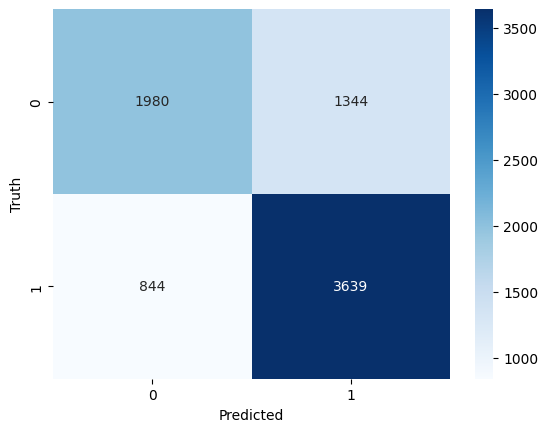

---------------------------------Predictions for F test sets: 
Test Brier Score Logistic Regression - Female: 0.1773
AUC - Logistic Regression - Female: 0.81


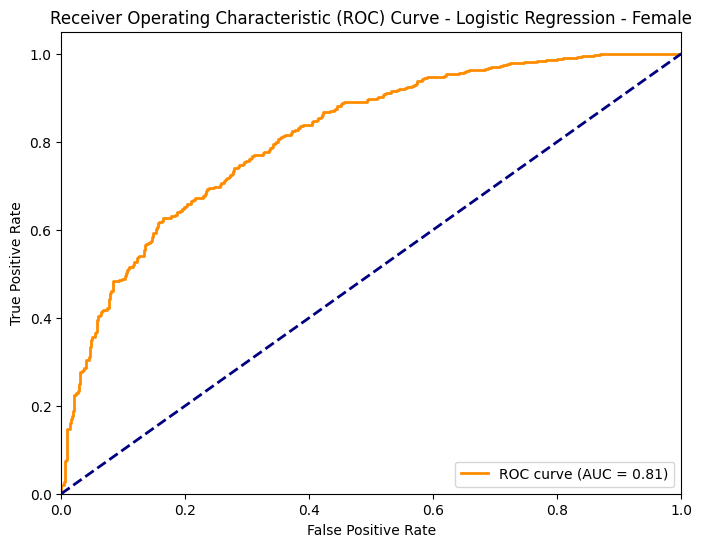

Metrics for Female sets....
Accuracy :  0.7336842105263158
Precision:  0.7282051282051282
Recall:  0.6589327146171694
F1 score:  0.6918392204628502


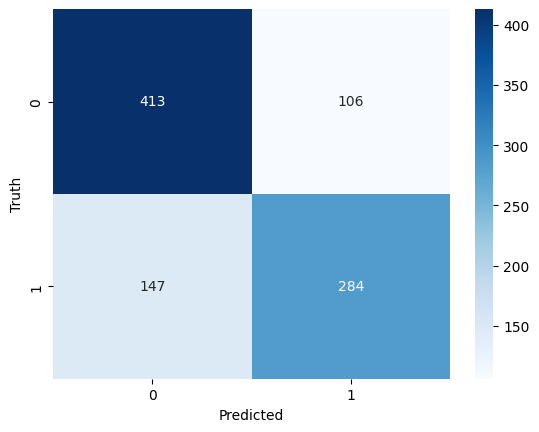

------------------------------Predictions for M test set: 
Test Brier Score - Logistic Regression - male: 0.1874
AUC - Logistic Regression - Male: 0.77


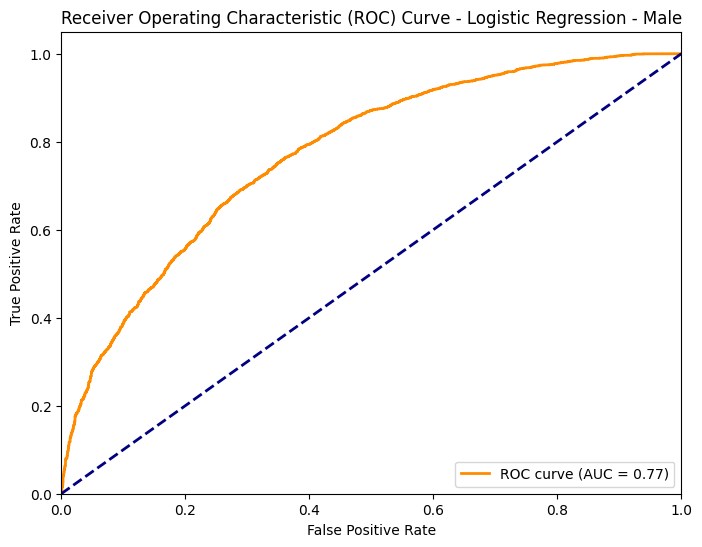

Metrics for male sets....
Accuracy :  0.7178066209712702
Precision:  0.7304593947311125
Recall:  0.8279861796643633
F1 score:  0.7761711972238287


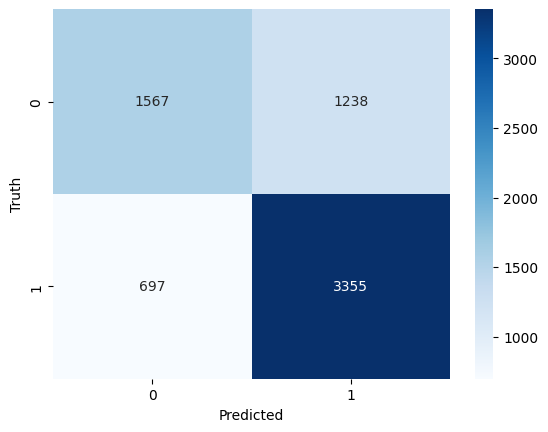

---------------------------------------------------------Predictions for  Model: XGBoost ---------------------------------------------------------
---------------------------------------------------------Predictions for complete test set: 
Test Brier Score XGBoost: 0.1701


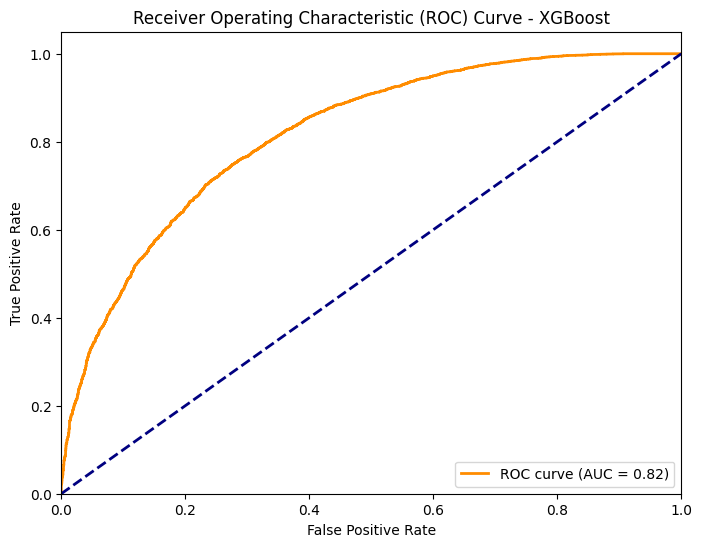

AUC - XGBoost: 0.82
Accuracy :  0.7451005507877546
Precision:  0.7517673197333872
Recall:  0.8302476020521972
F1 score:  0.7890608437566249


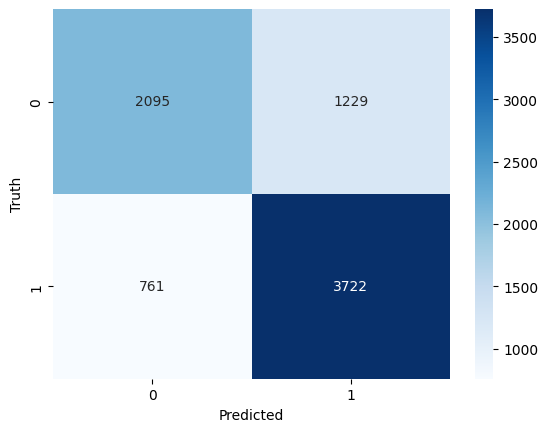

---------------------------------Predictions for F test sets: 
Test Brier Score XGBoost - Female: 0.1715
AUC - XGBoost - Female: 0.82


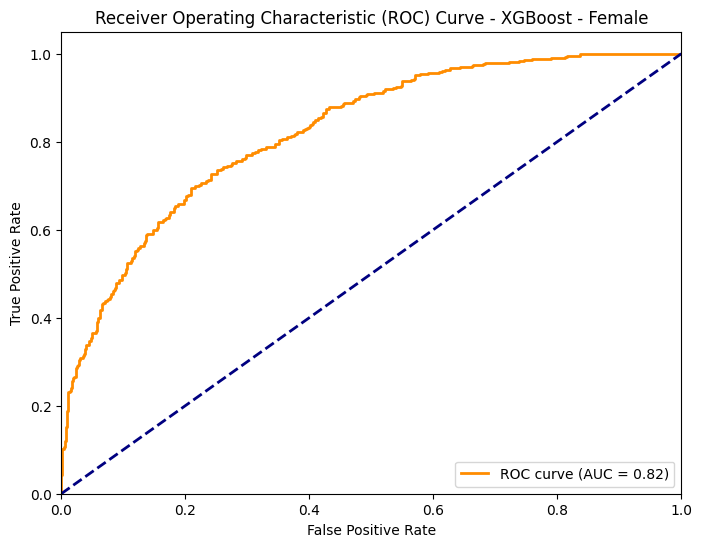

Metrics for Female sets....
Accuracy :  0.7389473684210527
Precision:  0.7152941176470589
Recall:  0.7053364269141531
F1 score:  0.7102803738317757


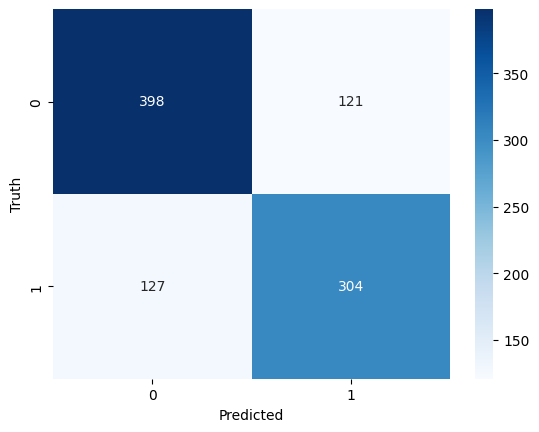

------------------------------Predictions for M test set: 
Test Brier Score - XGBoost - male: 0.1699
AUC - XGBoost - Male: 0.81


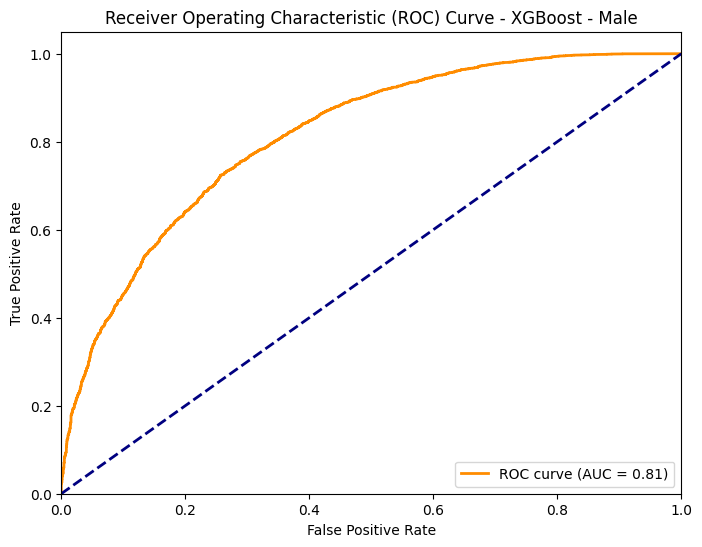

Metrics for male sets....
Accuracy :  0.7459530406883477
Precision:  0.7551922227132125
Recall:  0.8435340572556762
F1 score:  0.7969223595243647


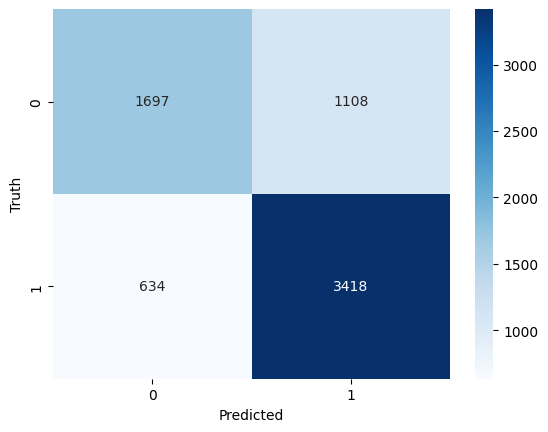

---------------------------------------------------------Predictions for  Model: CatBoost ---------------------------------------------------------
---------------------------------------------------------Predictions for complete test set: 
Test Brier Score CatBoost: 0.1686


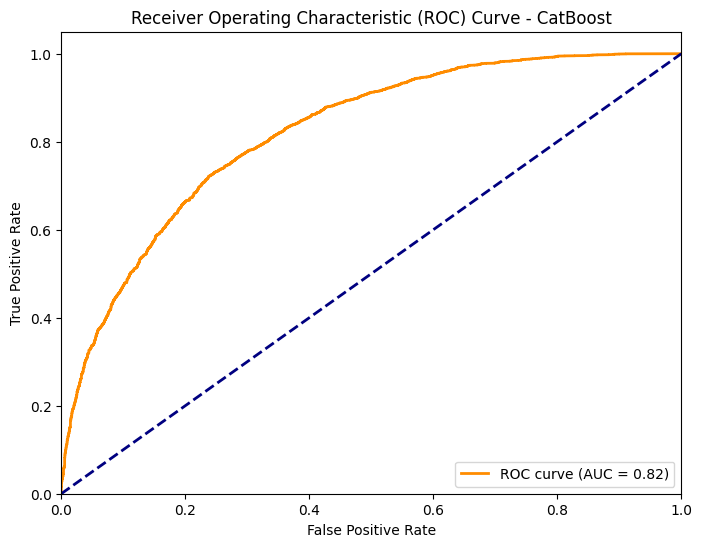

AUC - CatBoost: 0.82
Accuracy :  0.748302805174843
Precision:  0.7535239629480467
Recall:  0.8347089002899843
F1 score:  0.7920414858715208


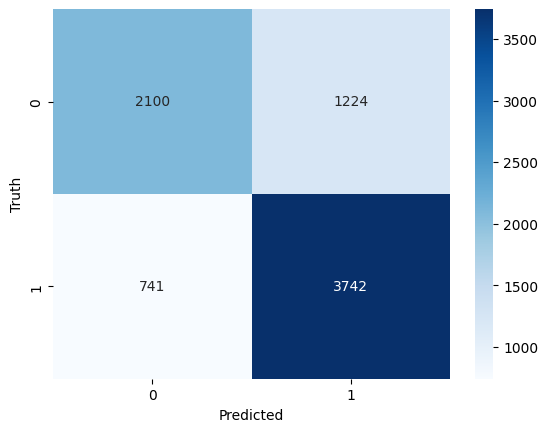

---------------------------------Predictions for F test sets: 
Test Brier Score CatBoost - Female: 0.1700
AUC - CatBoost - Female: 0.83


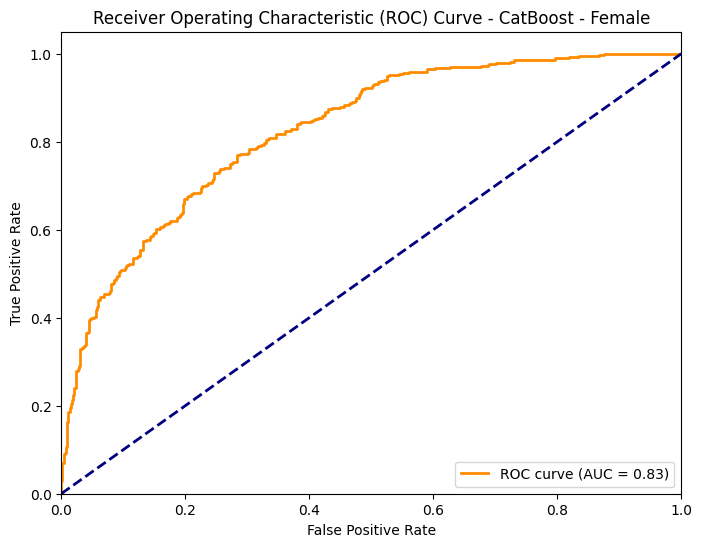

Metrics for Female sets....
Accuracy :  0.7368421052631579
Precision:  0.7170263788968825
Recall:  0.6937354988399071
F1 score:  0.705188679245283


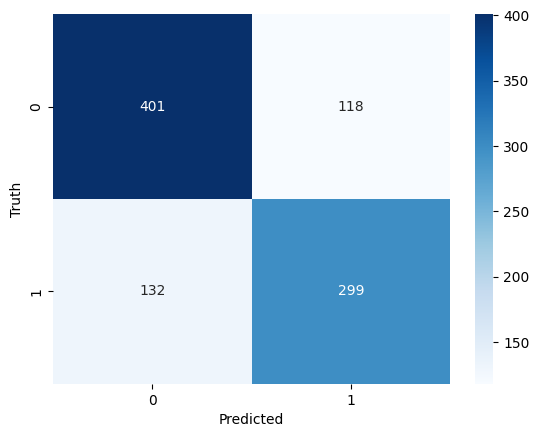

------------------------------Predictions for M test set: 
Test Brier Score - CatBoost - male: 0.1684
AUC - CatBoost - Male: 0.82


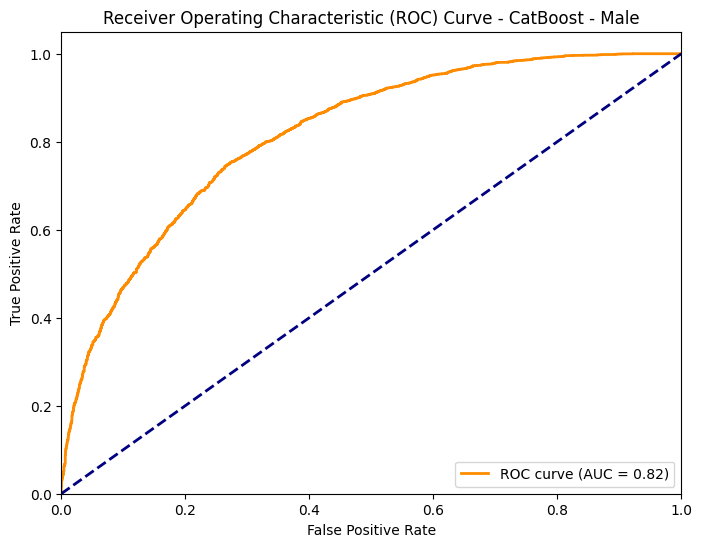

Metrics for male sets....
Accuracy :  0.7498906227213067
Precision:  0.75686964167949
Recall:  0.8497038499506416
F1 score:  0.8006045808626903


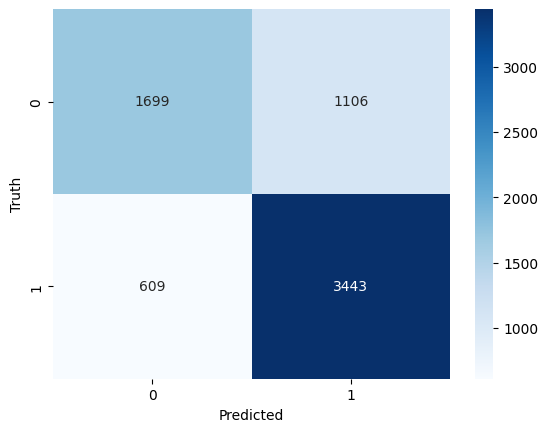

---------------------------------------------------------Predictions for  Model: SVM ---------------------------------------------------------
---------------------------------------------------------Predictions for complete test set: 
Test Brier Score SVM: 0.1864


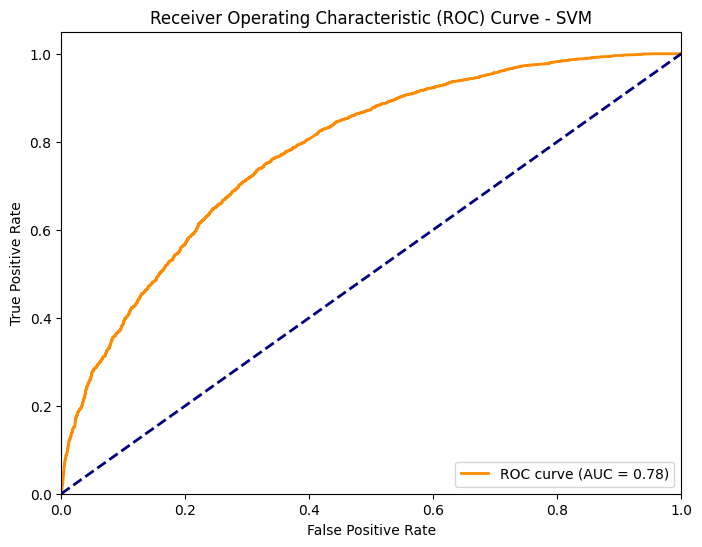

AUC - SVM: 0.78
Accuracy :  0.7192263353400794
Precision:  0.7276883323394951
Recall:  0.8166406424269462
F1 score:  0.7696026907714946


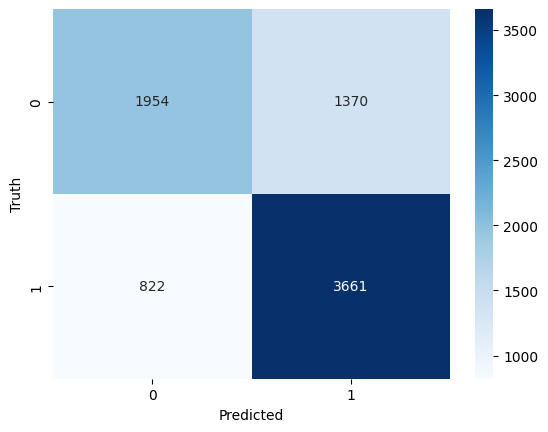

---------------------------------Predictions for F test sets: 
Test Brier Score SVM - Female: 0.1779
AUC - SVM - Female: 0.81


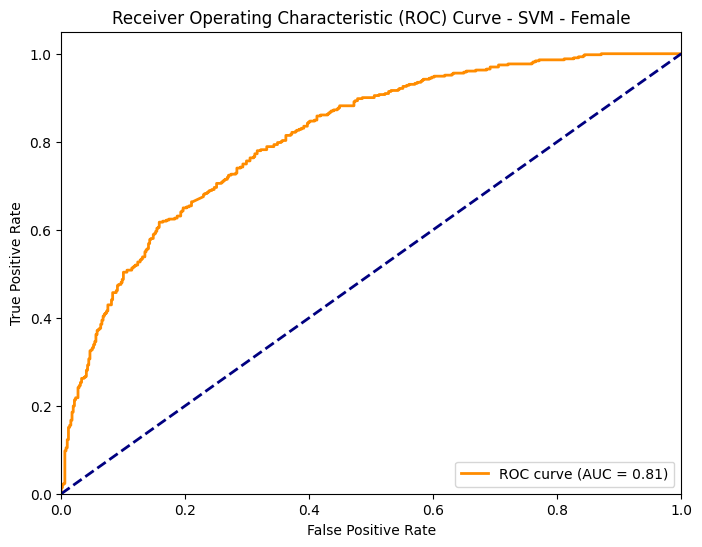

Metrics for Female sets....
Accuracy :  0.7273684210526316
Precision:  0.7097560975609756
Recall:  0.6751740139211136
F1 score:  0.6920332936979786


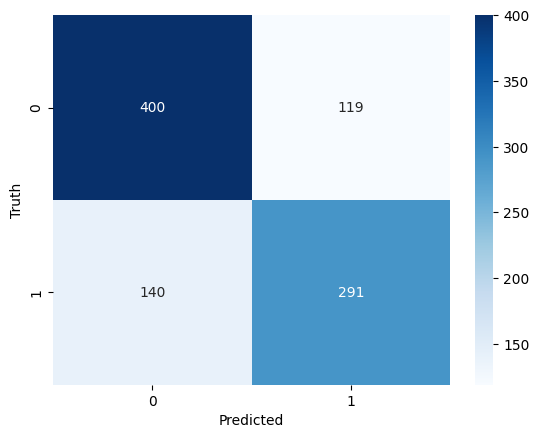

------------------------------Predictions for M test set: 
Test Brier Score - SVM - male: 0.1876
AUC - SVM - Male: 0.77


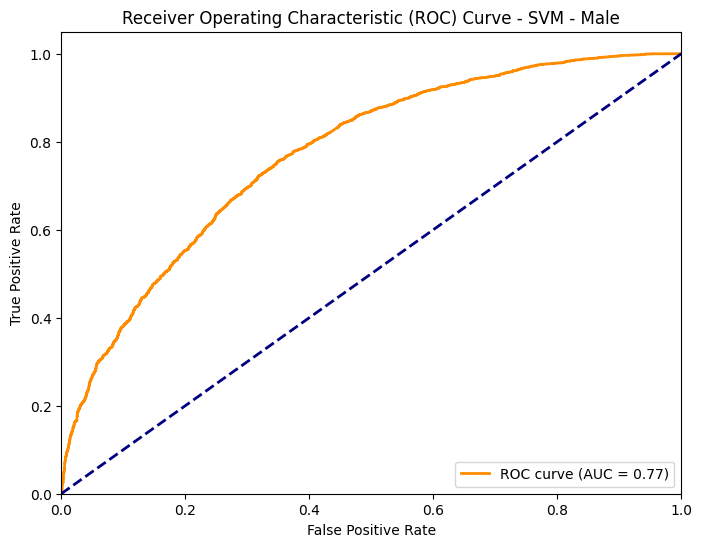

Metrics for male sets....
Accuracy :  0.7180982937144523
Precision:  0.7292793767582775
Recall:  0.8316880552813426
F1 score:  0.7771244090856683


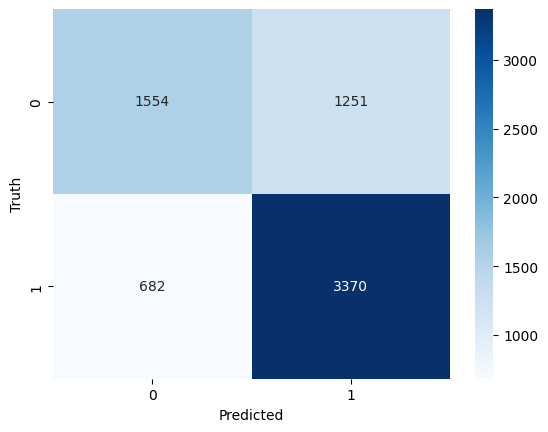

---------------------------------------------------------Predictions for  Model: KNN ---------------------------------------------------------
---------------------------------------------------------Predictions for complete test set: 
Test Brier Score KNN: 0.2119


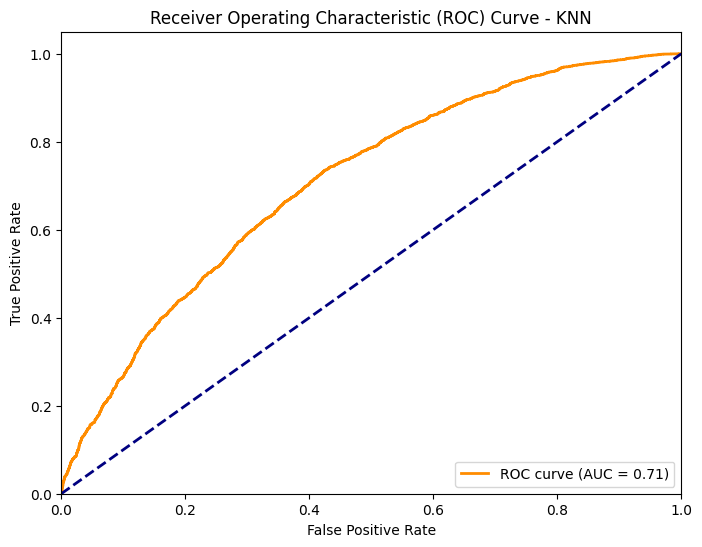

AUC - KNN: 0.71
Accuracy :  0.6661970026898937
Precision:  0.6706673940716494
Recall:  0.8226633950479589
F1 score:  0.7389300741334403


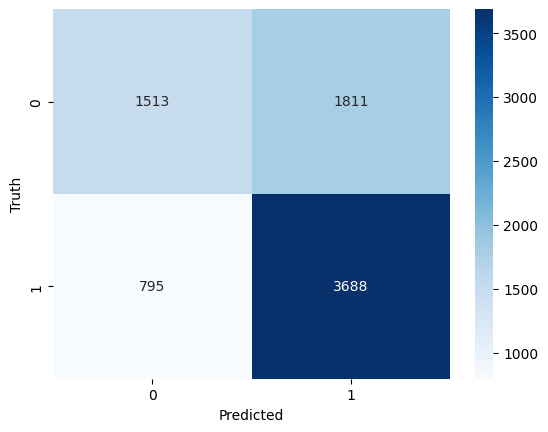

---------------------------------Predictions for F test sets: 
Test Brier Score KNN - Female: 0.2088
AUC - KNN - Female: 0.75


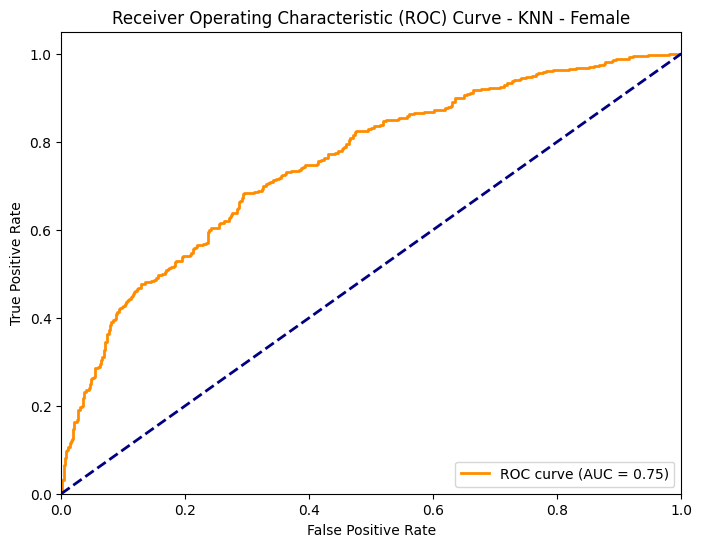

Metrics for Female sets....
Accuracy :  0.6589473684210526
Precision:  0.5978062157221207
Recall:  0.7587006960556845
F1 score:  0.6687116564417178


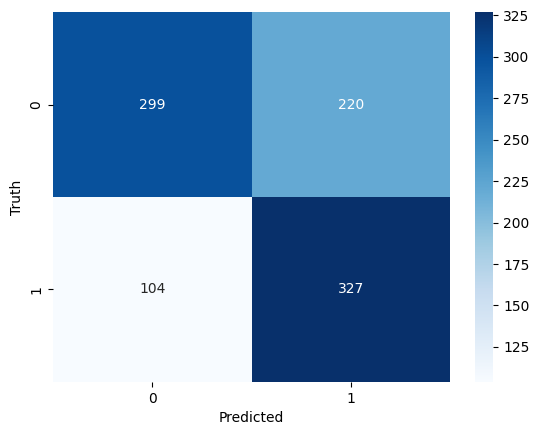

------------------------------Predictions for M test set: 
Test Brier Score - KNN - male: 0.2123
AUC - KNN - Male: 0.70


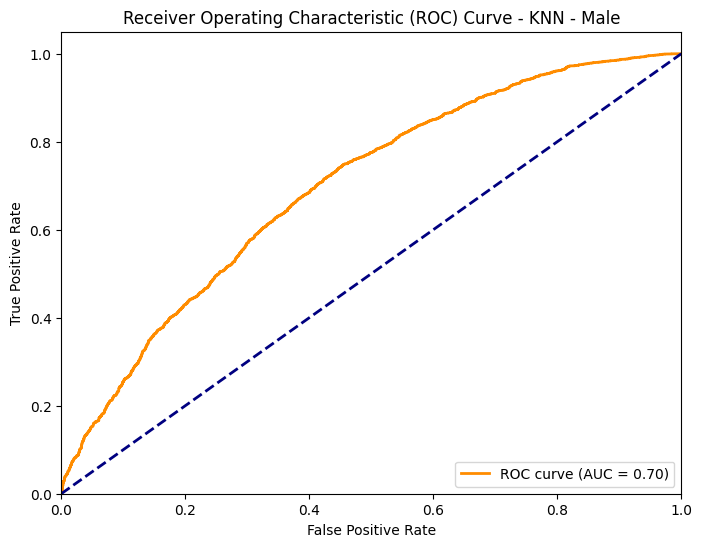

Metrics for male sets....
Accuracy :  0.6672014000291673
Precision:  0.6787156704361874
Recall:  0.829466929911155
F1 score:  0.7465570857396713


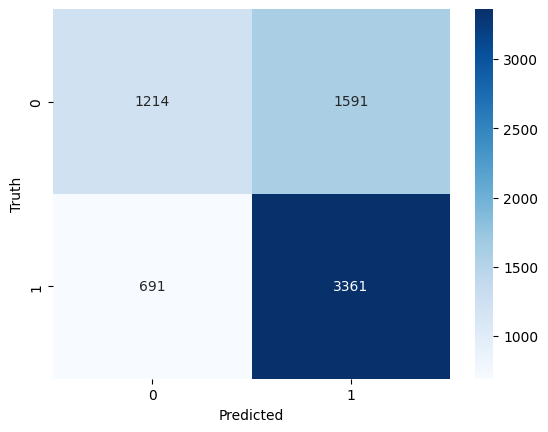

---------------------------------------------------------Predictions for  Model: bayesian_classifier ---------------------------------------------------------
---------------------------------------------------------Predictions for complete test set: 
Test Brier Score bayesian_classifier: 0.2796


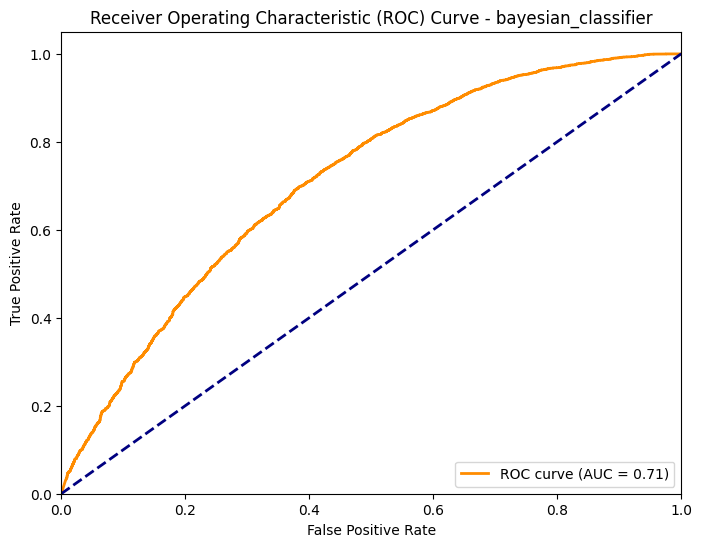

AUC - bayesian_classifier: 0.71
Accuracy :  0.6693992570769822
Precision:  0.6953574363188167
Recall:  0.7550747267454829
F1 score:  0.723986739386162


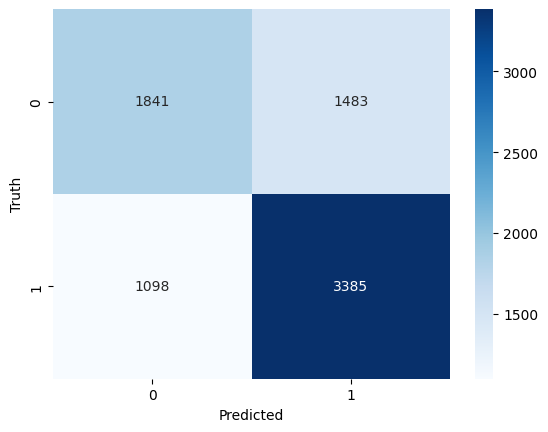

---------------------------------Predictions for F test sets: 
Test Brier Score bayesian_classifier - Female: 0.2546
AUC - bayesian_classifier - Female: 0.75


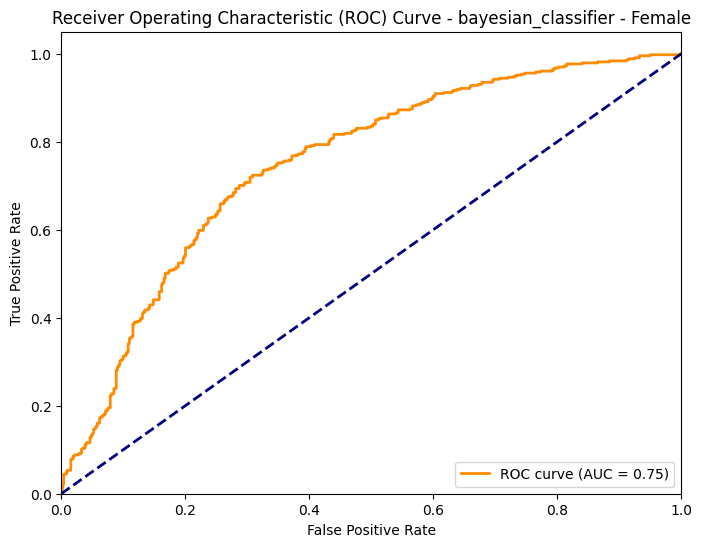

Metrics for Female sets....
Accuracy :  0.6905263157894737
Precision:  0.6876712328767123
Recall:  0.5823665893271461
F1 score:  0.6306532663316583


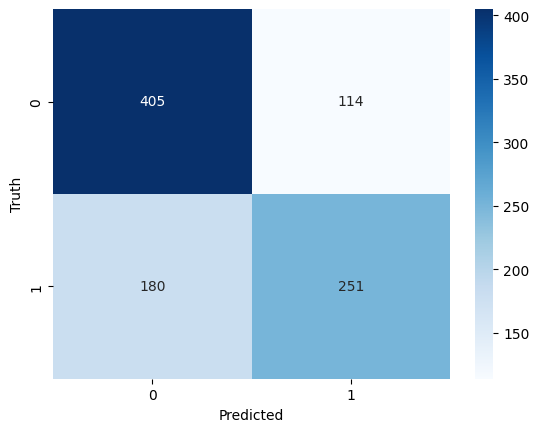

------------------------------Predictions for M test set: 
Test Brier Score - bayesian_classifier - male: 0.2831
AUC - bayesian_classifier - Male: 0.70


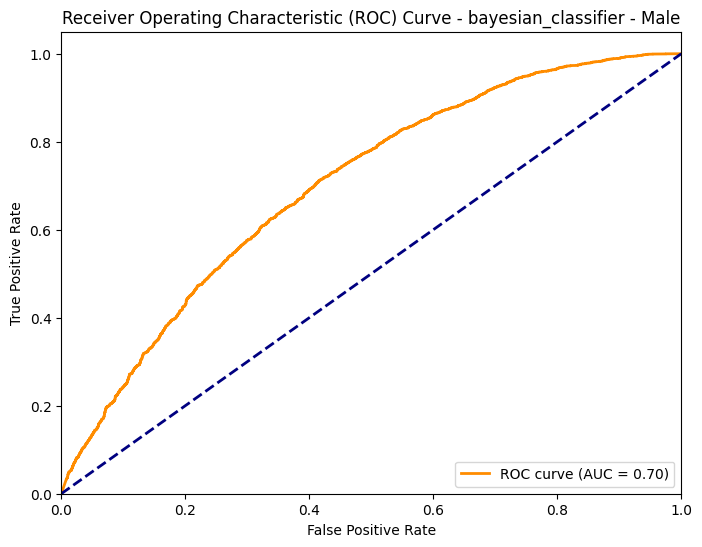

Metrics for male sets....
Accuracy :  0.6664722181712119
Precision:  0.6959804574727959
Recall:  0.7734452122408687
F1 score:  0.7326709526592635


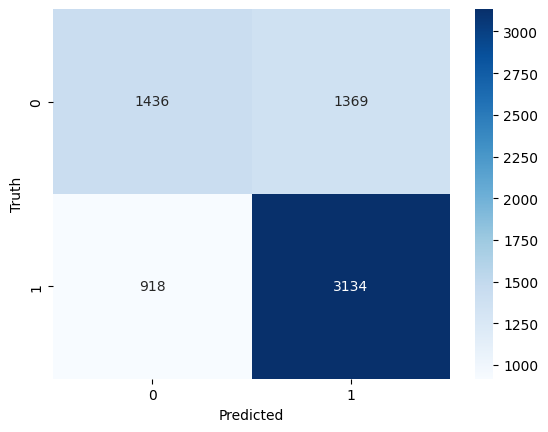

In [133]:
""" 
Model wise predictions. 

"""
### Load the data from cell 4 

# Male and Female seperate comparison
X_test_female = X_test[X_test['Gender'] ==0 ]
y_test_female = test_data[test_data['Gender']== 0]['Recidivism_Within_3years']
X_test_male = X_test[X_test['Gender'] ==1 ] 
y_test_male = test_data[test_data['Gender']== 1]['Recidivism_Within_3years']


# prediction 
print("Total count female: ", len(y_test_female))
print("Total count male: ", len(y_test_male))

for model_name,clf in model_dict.items():
    if model_name == 'Random Forest':
        continue    
    print(f"---------------------------------------------------------Predictions for  Model: {model_name} ---------------------------------------------------------")

    # Complete test set  predictions 
    print(f"---------------------------------------------------------Predictions for complete test set: ")
    
    # Predict probabilities for the positive class
    y_prob = clf.predict_proba(X_test)[:,1]
    y_pred = clf.predict(X_test)

    # brier score 
    test_brier_score = custom_brier_score(y_test, y_prob)
    print(f"Test Brier Score {model_name}: {test_brier_score:.4f}")

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    # Print AUC value
    print(f'AUC - {model_name}: {roc_auc:.2f}')


    # Accuracy, Precision, Recall, F1 score
    print(f"Accuracy : ", accuracy_score(y_test, y_pred))
    print(f"Precision: ", precision_score(y_test, y_pred))
    print(f"Recall: ", recall_score(y_test, y_pred))
    print(f"F1 score: ", f1_score(y_test, y_pred))


    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # seanborn heatmap 
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()
    
    # predicting for Female and Male seperately 
    print(f"---------------------------------Predictions for F test sets: ")

    # Predict probabilities for the positive class
    y_prob = clf.predict_proba(X_test_female)[:,1]
    y_pred = clf.predict(X_test_female)

    # brier score 
    test_brier_score_female = custom_brier_score(y_test_female,y_prob)
    print(f"Test Brier Score {model_name} - Female: {test_brier_score_female:.4f}")

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_female, y_prob)
    roc_auc = auc(fpr, tpr)

    # Print AUC value
    print(f'AUC - {model_name} - Female: {roc_auc:.2f}')

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name} - Female')
    plt.legend(loc='lower right')
    plt.show()

    # Accuracy, Precision, Recall, F1 score
    print("Metrics for Female sets....")
    print(f"Accuracy : ", accuracy_score(y_test_female, y_pred))
    print(f"Precision: ", precision_score(y_test_female, y_pred))
    print(f"Recall: ", recall_score(y_test_female, y_pred))
    print(f"F1 score: ", f1_score(y_test_female, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test_female, y_pred)
    # seanborn heatmap 
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

    # predicting for Female and Male seperately 
    print(f"------------------------------Predictions for M test set: ")

    # Predict probabilities for the positive class
    y_prob = clf.predict_proba(X_test_male)[:,1]
    y_pred = clf.predict(X_test_male)

    # brier score 
    test_brier_score_male = custom_brier_score(y_test_male,y_prob)
    print(f"Test Brier Score - {model_name} - male: {test_brier_score_male:.4f}")

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_male, y_prob)
    roc_auc = auc(fpr, tpr)
    # Print AUC value
    print(f'AUC - {model_name} - Male: {roc_auc:.2f}')

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name} - Male')
    plt.legend(loc='lower right')
    plt.show()


    # Accuracy, Precision, Recall, F1 score
    print("Metrics for male sets....")
    print(f"Accuracy : ", accuracy_score(y_test_male, y_pred))
    print(f"Precision: ", precision_score(y_test_male, y_pred))
    print(f"Recall: ", recall_score(y_test_male, y_pred))
    print(f"F1 score: ", f1_score(y_test_male, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test_male, y_pred)
    # seanborn heatmap 
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()



Test Brier Score: 0.1686


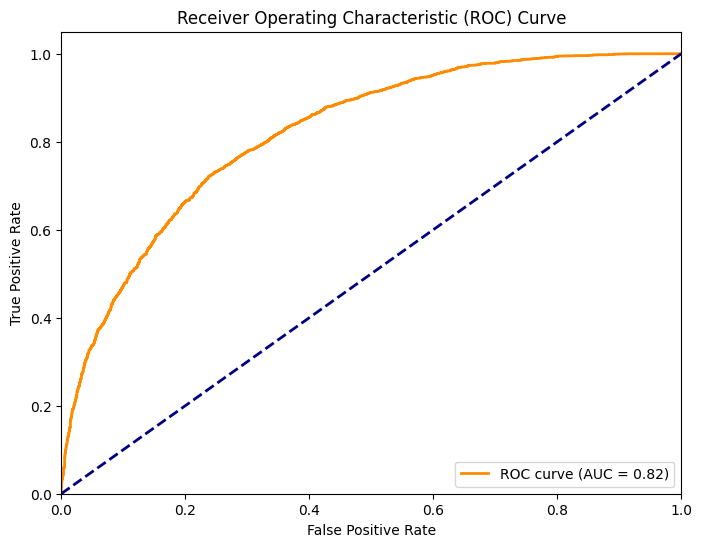

AUC: 0.82
Accuracy:  0.748302805174843
Precision:  0.7535239629480467
Recall:  0.8347089002899843
F1 score:  0.7920414858715208


In [69]:

# Predict probabilities for the positive class
y_prob = best_classifier.predict_proba(X_test)[:,1]

# brier score 
test_brier_score = custom_brier_score(y_test, y_prob)
print(f"Test Brier Score: {test_brier_score:.4f}")

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC value
print(f'AUC: {roc_auc:.2f}')


# Accuracy, Precision, Recall, F1 score 
y_pred = best_classifier.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))



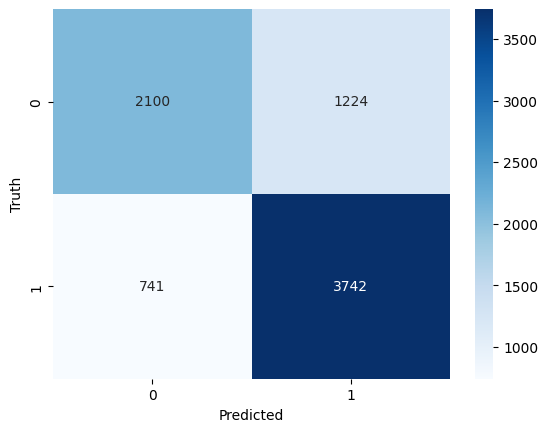

In [33]:
# F1 score 
y_pred = best_classifier.predict(X_test)
f1_score(y_test, y_pred)

# Accuracy score
accuracy_score(y_test, y_pred)

# Precision score
precision_score(y_test, y_pred)

# Recall score
recall_score(y_test, y_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm
# seanborn heatmap 
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


Total count female:  950
Total count male:  6857
Test Brier Score - Female: 0.1700


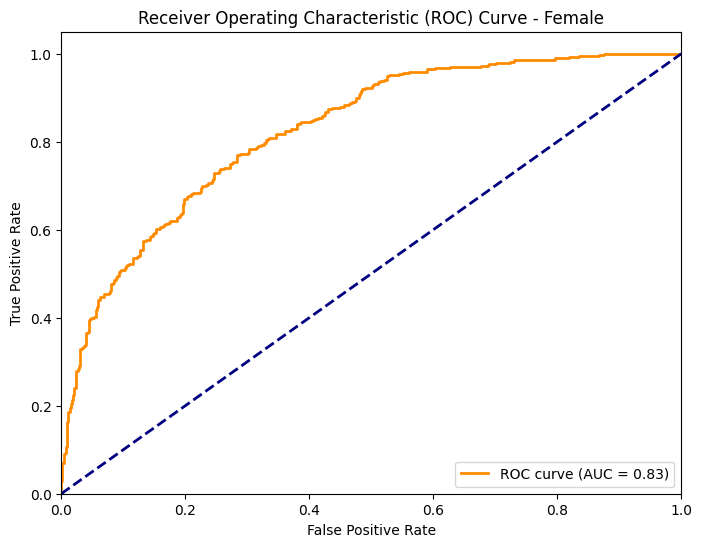

AUC - Female: 0.83
Test Brier Score - male: 0.1684


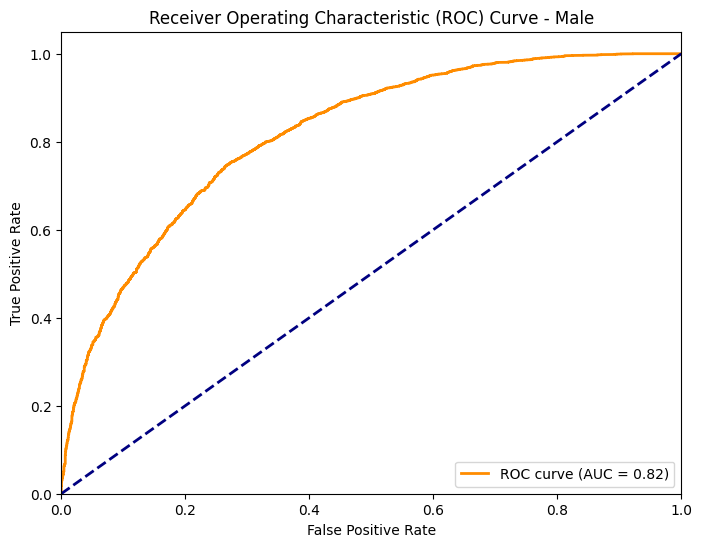

AUC - Male: 0.82


In [36]:
# Male and Female seperate comparison
X_test_female = X_test[X_test['Gender'] ==0 ]
y_test_female = test_data[test_data['Gender']== 0]['Recidivism_Within_3years']
X_test_male = X_test[X_test['Gender'] ==1 ] 
y_test_male = test_data[test_data['Gender']== 1]['Recidivism_Within_3years']


# prediction 
print("Total count female: ", len(y_test_female))
print("Total count male: ", len(y_test_male))

# Predict probabilities for the positive class
y_prob = best_classifier.predict_proba(X_test_female)[:,1]

# brier score 
test_brier_score_female = custom_brier_score(y_test_female,y_prob)
print(f"Test Brier Score - Female: {test_brier_score_female:.4f}")

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_female, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Female')
plt.legend(loc='lower right')
plt.show()

# Print AUC value
print(f'AUC - Female: {roc_auc:.2f}')

# Predict probabilities for the positive class
y_prob = best_classifier.predict_proba(X_test_male)[:,1]

# brier score 
test_brier_score_male = custom_brier_score(y_test_male,y_prob)
print(f"Test Brier Score - male: {test_brier_score_male:.4f}")

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_male, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Male')
plt.legend(loc='lower right')
plt.show()

# Print AUC value
print(f'AUC - Male: {roc_auc:.2f}')


In [37]:
""" 
# Training : 


Results for Logistic Regression:                                                                                     
Best Parameters: {'model__C': 1, 'model__penalty': 'l2'}                                                             
Brier Score: 0.1851                                                                                                  
AUC: 0.7048


Results for Random Forest:
Best Parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_est$mators': 200}
Brier Score: 0.1835
AUC: 0.7129


Results for XGBoost:
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}                   
Brier Score: 0.1728
AUC: 0.7298


Results for CatBoost:
Best Parameters: {'model__depth': 5, 'model__iterations': 300, 'model__learning_rate': 0.1}                         
Brier Score: 0.1710
AUC: 0.7332

Best Classifier: CatBoost
Test Brier Score: 0.2517
Test AUC: 0.7332
Best classifier model saved to best_classifier_CatBoost.joblib                                                      
AUC: 0.73

"""

" \nResults for Logistic Regression:                                                                                     \nBest Parameters: {'model__C': 1, 'model__penalty': 'l2'}                                                             \nBrier Score: 0.1851                                                                                                  \nAUC: 0.7048\n\n\nResults for Random Forest:\nBest Parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_est$mators': 200}\nBrier Score: 0.1835\nAUC: 0.7129\n\n\nResults for XGBoost:\nBest Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}                   \nBrier Score: 0.1728\nAUC: 0.7298\n\n\nResults for CatBoost:\nBest Parameters: {'model__depth': 5, 'model__iterations': 300, 'model__learning_rate': 0.1}                         \nBrier Score: 0.1710\nAUC: 0.7332\n\nBest Classifier: CatBoost\nTest Brier Score: 0.2517\nTest AUC: 0.7332

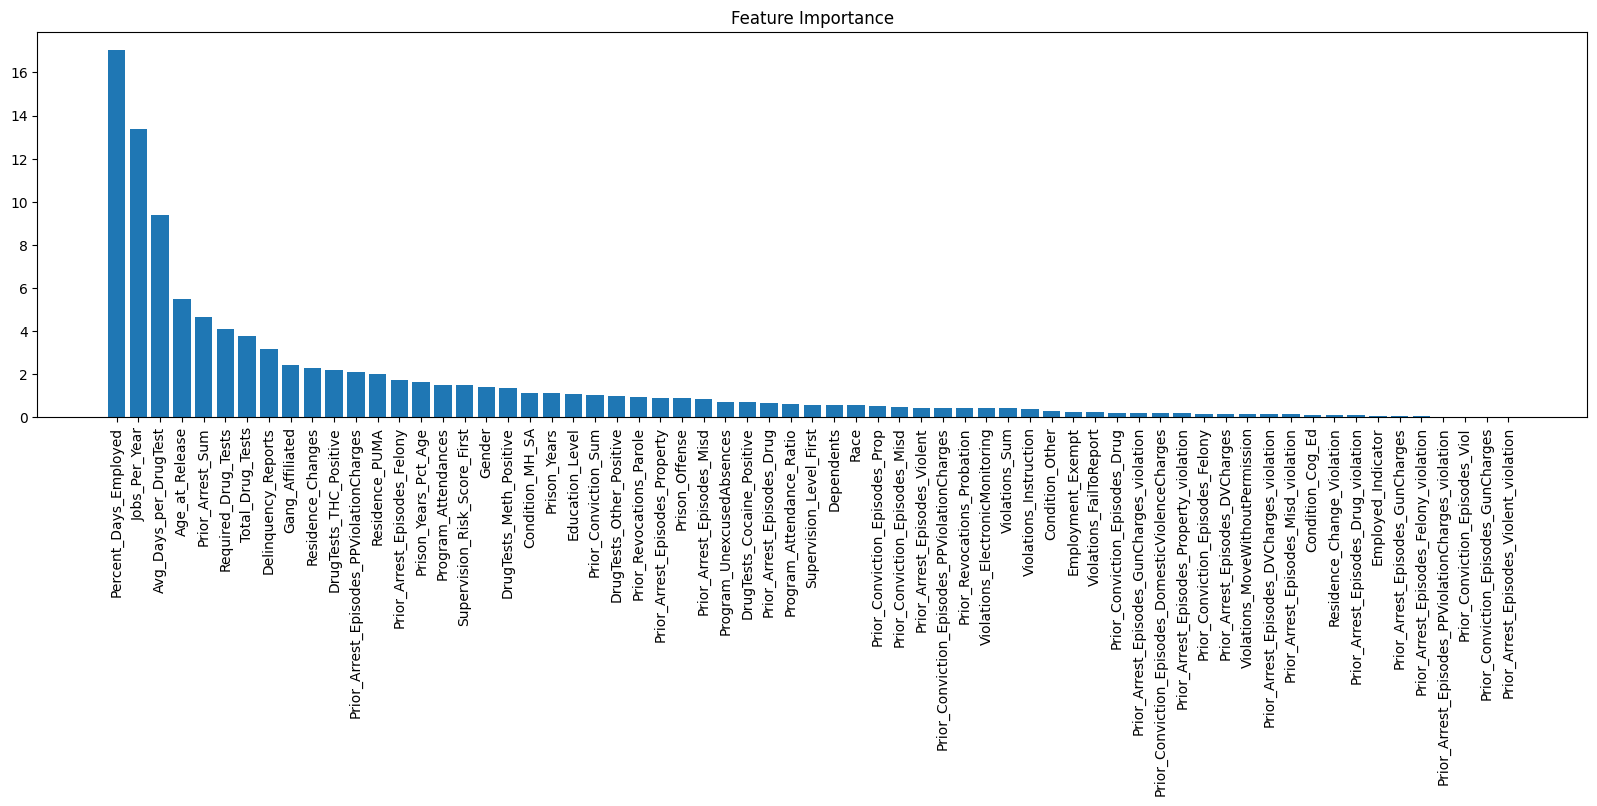

Percent_Days_Employed         : 1703.26%
Jobs_Per_Year                 : 1337.87%
Avg_Days_per_DrugTest         : 936.14%
Age_at_Release                : 549.95%
Prior_Arrest_Sum              : 466.23%
Required_Drug_Tests           : 408.22%
Total_Drug_Tests              : 377.84%
Delinquency_Reports           : 316.74%
Gang_Affiliated               : 239.43%
Residence_Changes             : 227.72%
DrugTests_THC_Positive        : 217.76%
Prior_Arrest_Episodes_PPViolationCharges: 207.54%
Residence_PUMA                : 197.18%
Prior_Arrest_Episodes_Felony  : 173.28%
Prison_Years_Pct_Age          : 161.13%
Program_Attendances           : 149.18%
Supervision_Risk_Score_First  : 149.17%
Gender                        : 138.56%
DrugTests_Meth_Positive       : 133.88%
Condition_MH_SA               : 111.37%
Prison_Years                  : 110.81%
Education_Level               : 108.47%
Prior_Conviction_Sum          : 103.95%
DrugTests_Other_Positive      : 95.76%
Prior_Revocations_Parole     

In [44]:
# for the best classifier; try to check the feature importance 
# Load saved sklearn model
best_classifier = joblib.load('best_classifier_CatBoost.joblib')

# Get feature importances
feature_importances = best_classifier.named_steps['model'].get_feature_importance()

# here the feature importance; i.e. y axis represents the importance of the feature in terms of 

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20, 5))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train.shape[1]), feature_importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)


# Show plot
plt.show()

# Print feature importance
for name, importance in zip(names, feature_importances[indices]):
    print(f"{name:<30}: {importance:>6.2%}")



(65,)


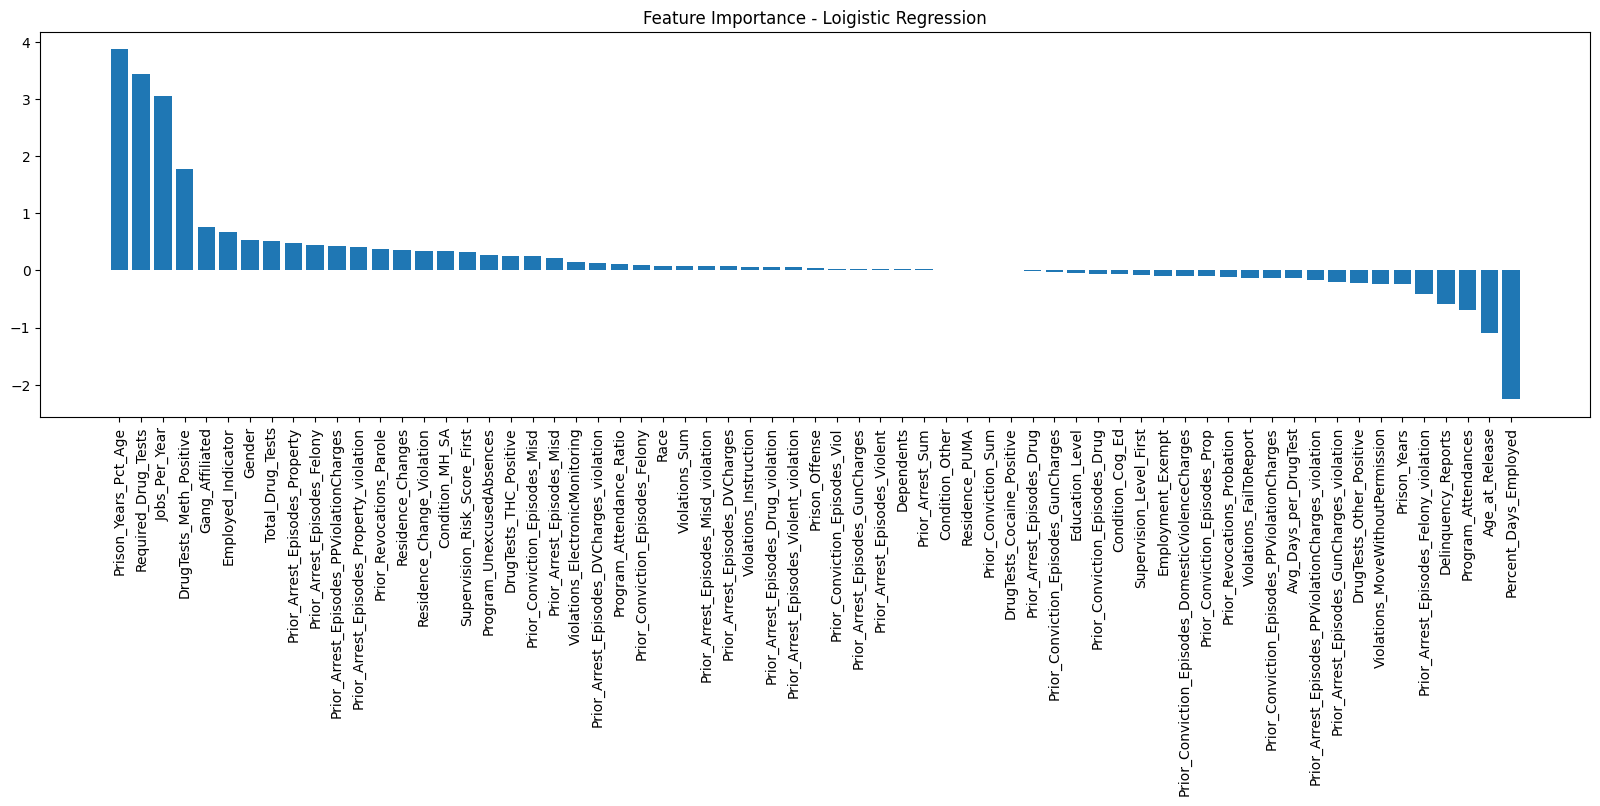

Prison_Years_Pct_Age          : 386.95%
Required_Drug_Tests           : 344.59%
Jobs_Per_Year                 : 305.71%
DrugTests_Meth_Positive       : 177.86%
Gang_Affiliated               : 76.82%
Employed_Indicator            : 67.44%
Gender                        : 53.32%
Total_Drug_Tests              : 51.34%
Prior_Arrest_Episodes_Property: 48.56%
Prior_Arrest_Episodes_Felony  : 44.75%
Prior_Arrest_Episodes_PPViolationCharges: 41.90%
Prior_Arrest_Episodes_Property_violation: 41.03%
Prior_Revocations_Parole      : 36.89%
Residence_Changes             : 36.08%
Residence_Change_Violation    : 34.58%
Condition_MH_SA               : 34.10%
Supervision_Risk_Score_First  : 32.32%
Program_UnexcusedAbsences     : 27.18%
DrugTests_THC_Positive        : 24.98%
Prior_Conviction_Episodes_Misd: 24.88%
Prior_Arrest_Episodes_Misd    : 21.88%
Violations_ElectronicMonitoring: 15.25%
Prior_Arrest_Episodes_DVCharges_violation: 13.54%
Program_Attendance_Ratio      : 11.70%
Prior_Conviction_Episodes_Fe

In [128]:

# Feature importance

# Get feature importances
feature_importances = model_dict['Logistic Regression'].named_steps['model'].coef_[0]


# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20, 5))

# Create plot title
plt.title(f"Feature Importance - Loigistic Regression")

# Add bars
plt.bar(range(X_train.shape[1]), feature_importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

# Print feature importance
for name, importance in zip(names, feature_importances[indices]):
    print(f"{name:<30}: {importance:>6.2%}")

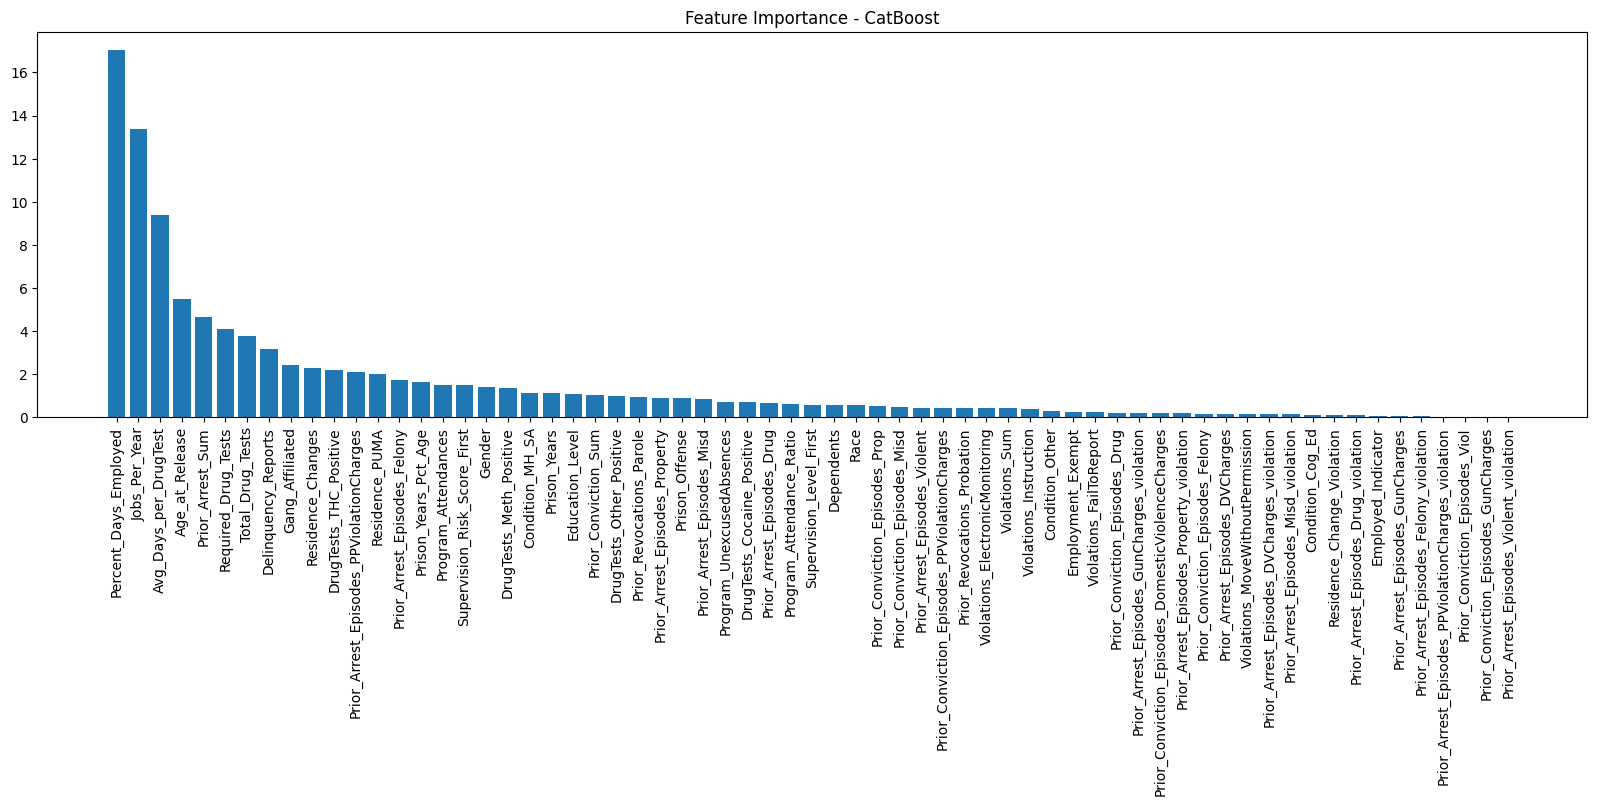

Percent_Days_Employed         : 1703.26%
Jobs_Per_Year                 : 1337.87%
Avg_Days_per_DrugTest         : 936.14%
Age_at_Release                : 549.95%
Prior_Arrest_Sum              : 466.23%
Required_Drug_Tests           : 408.22%
Total_Drug_Tests              : 377.84%
Delinquency_Reports           : 316.74%
Gang_Affiliated               : 239.43%
Residence_Changes             : 227.72%
DrugTests_THC_Positive        : 217.76%
Prior_Arrest_Episodes_PPViolationCharges: 207.54%
Residence_PUMA                : 197.18%
Prior_Arrest_Episodes_Felony  : 173.28%
Prison_Years_Pct_Age          : 161.13%
Program_Attendances           : 149.18%
Supervision_Risk_Score_First  : 149.17%
Gender                        : 138.56%
DrugTests_Meth_Positive       : 133.88%
Condition_MH_SA               : 111.37%
Prison_Years                  : 110.81%
Education_Level               : 108.47%
Prior_Conviction_Sum          : 103.95%
DrugTests_Other_Positive      : 95.76%
Prior_Revocations_Parole     

In [115]:

# Feature importance

# Get feature importances
feature_importances = model_dict['CatBoost'].named_steps['model'].get_feature_importance()

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20, 5))

# Create plot title
plt.title(f"Feature Importance - CatBoost")

# Add bars
plt.bar(range(X_train.shape[1]), feature_importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

# Print feature importance
for name, importance in zip(names, feature_importances[indices]):
    print(f"{name:<30}: {importance:>6.2%}")

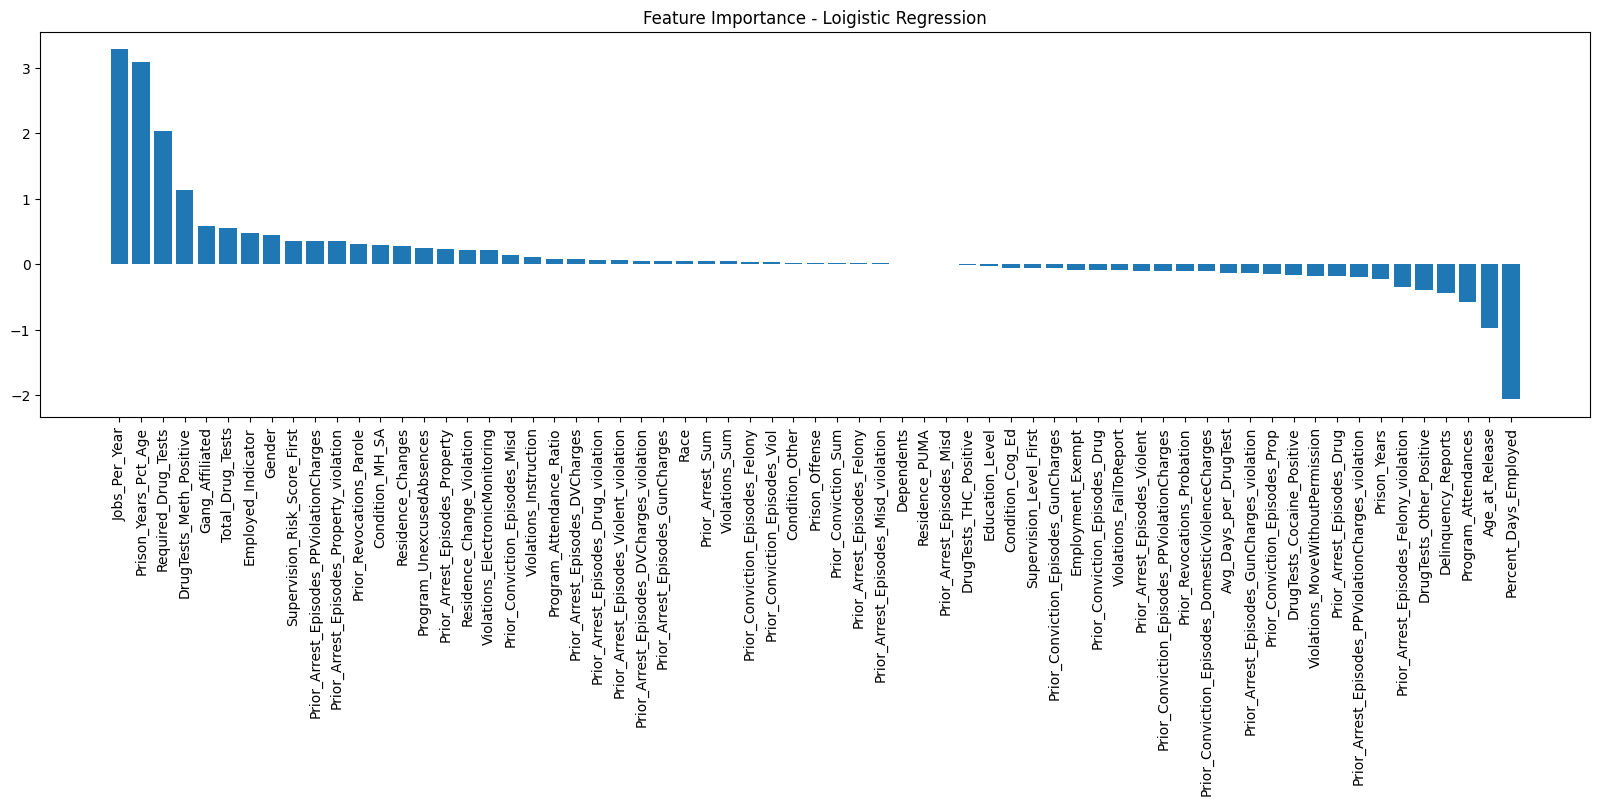

Jobs_Per_Year                 : 328.40%
Prison_Years_Pct_Age          : 309.32%
Required_Drug_Tests           : 203.41%
DrugTests_Meth_Positive       : 112.76%
Gang_Affiliated               : 59.11%
Total_Drug_Tests              : 54.70%
Employed_Indicator            : 48.15%
Gender                        : 45.42%
Supervision_Risk_Score_First  : 36.08%
Prior_Arrest_Episodes_PPViolationCharges: 35.21%
Prior_Arrest_Episodes_Property_violation: 35.13%
Prior_Revocations_Parole      : 31.48%
Condition_MH_SA               : 29.84%
Residence_Changes             : 27.35%
Program_UnexcusedAbsences     : 24.12%
Prior_Arrest_Episodes_Property: 22.69%
Residence_Change_Violation    : 22.10%
Violations_ElectronicMonitoring: 21.43%
Prior_Conviction_Episodes_Misd: 13.36%
Violations_Instruction        : 10.63%
Program_Attendance_Ratio      :  8.71%
Prior_Arrest_Episodes_DVCharges:  8.44%
Prior_Arrest_Episodes_Drug_violation:  6.66%
Prior_Arrest_Episodes_Violent_violation:  5.88%
Prior_Arrest_Episodes_D

In [130]:

# Feature importance

# Get feature importances
feature_importances = model_dict['SVM'].named_steps['model'].coef_[0]
# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]


# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20, 5))

# Create plot title
plt.title(f"Feature Importance - SVM")

# Add bars
plt.bar(range(X_train.shape[1]), feature_importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

# Print feature importance
for name, importance in zip(names, feature_importances[indices]):
    print(f"{name:<30}: {importance:>6.2%}")

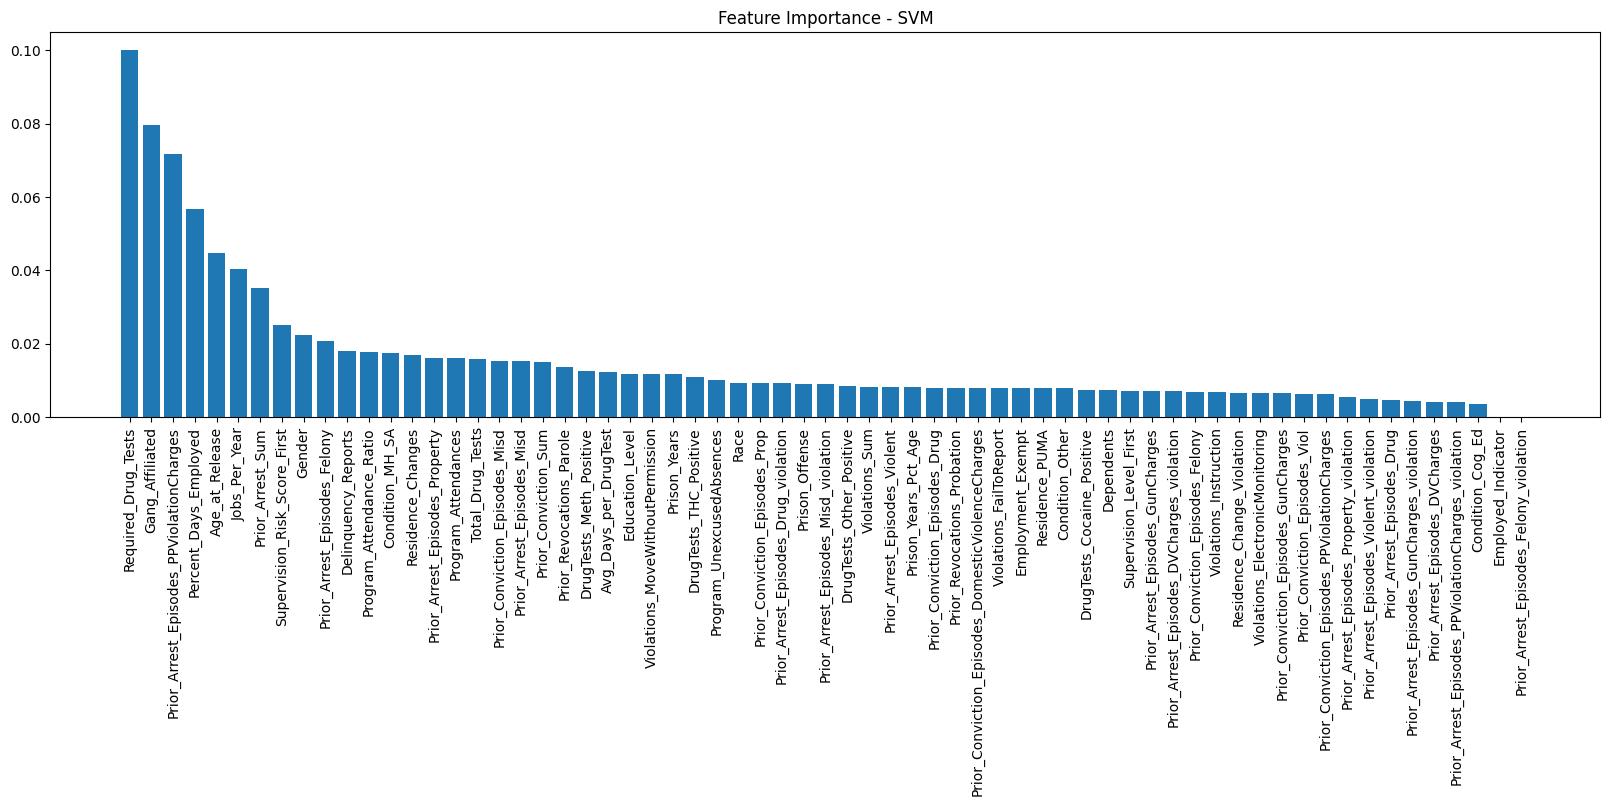

Required_Drug_Tests           : 10.00%
Gang_Affiliated               :  7.95%
Prior_Arrest_Episodes_PPViolationCharges:  7.16%
Percent_Days_Employed         :  5.68%
Age_at_Release                :  4.48%
Jobs_Per_Year                 :  4.04%
Prior_Arrest_Sum              :  3.53%
Supervision_Risk_Score_First  :  2.52%
Gender                        :  2.23%
Prior_Arrest_Episodes_Felony  :  2.06%
Delinquency_Reports           :  1.79%
Program_Attendance_Ratio      :  1.77%
Condition_MH_SA               :  1.73%
Residence_Changes             :  1.68%
Prior_Arrest_Episodes_Property:  1.61%
Program_Attendances           :  1.61%
Total_Drug_Tests              :  1.59%
Prior_Conviction_Episodes_Misd:  1.53%
Prior_Arrest_Episodes_Misd    :  1.51%
Prior_Conviction_Sum          :  1.49%
Prior_Revocations_Parole      :  1.36%
DrugTests_Meth_Positive       :  1.25%
Avg_Days_per_DrugTest         :  1.24%
Education_Level               :  1.18%
Violations_MoveWithoutPermission:  1.16%
Prison_Years 

In [132]:

# Feature importance

# Get feature importances
feature_importances = model_dict['XGBoost'].named_steps['model'].feature_importances_
# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]


# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20, 5))

# Create plot title
plt.title(f"Feature Importance - XGBoost")

# Add bars
plt.bar(range(X_train.shape[1]), feature_importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

# Print feature importance
for name, importance in zip(names, feature_importances[indices]):
    print(f"{name:<30}: {importance:>6.2%}")

# More feat selection analysis: 

1. All available in catboost 
2. SHAP 

## Running CatBoost Pre parole feats: 

1. Drop the post parole features  
2. Take the Important features 

In [57]:
# load the catboost best para to check which hyper paras to use 
best_params = joblib.load('./trained_models/CatBoost_best_params.pkl')
best_params


{'model__iterations': 300, 'model__learning_rate': 0.1, 'model__max_depth': 5}

In [58]:
# catboost model using AUC as the metric
Cat_model = cb.CatBoostClassifier(verbose=0, depth=5, iterations=300, 
                                    learning_rate=0.1, 
                                    eval_metric='AUC',
                                    random_seed=42)

In [59]:
""" 
Dropping the feats 

"""
# Load the data 
train_data = pd.read_csv('../data/Recvidism_extra_feat_train.csv')
test_data = pd.read_csv('../data/Recvidism_extra_feat_test.csv')

# length of train and test data  
print("Length of train data: ", len(train_data))
print("Length of test data: ", len(test_data))

print("Length of train data feat (before): ", len(train_data.columns))

# Remove variables thaat are determined only after prison release
train_data.drop(['Supervision_Risk_Score_First', 'Supervision_Level_First',
         'Violations_ElectronicMonitoring', 'Violations_FailToReport','Violations_FailToReport', 'Violations_MoveWithoutPermission',
         'Delinquency_Reports', 'Program_Attendances', 'Program_UnexcusedAbsences','Residence_Changes', 
         'DrugTests_THC_Positive', 'DrugTests_Cocaine_Positive','DrugTests_Meth_Positive', 'DrugTests_Other_Positive', 
         'Percent_Days_Employed', 'Jobs_Per_Year', 'Employment_Exempt',
         'Required_Drug_Tests', 'Program_Attendance_Ratio', 'Employed_Indicator', 'Total_Drug_Tests', 'Residence_Change_Violation',], axis=1, inplace=True)

test_data.drop(['Supervision_Risk_Score_First', 'Supervision_Level_First',
         'Violations_ElectronicMonitoring', 'Violations_FailToReport','Violations_FailToReport', 'Violations_MoveWithoutPermission',
         'Delinquency_Reports', 'Program_Attendances', 'Program_UnexcusedAbsences','Residence_Changes', 
         'DrugTests_THC_Positive', 'DrugTests_Cocaine_Positive','DrugTests_Meth_Positive', 'DrugTests_Other_Positive', 
         'Percent_Days_Employed', 'Jobs_Per_Year', 'Employment_Exempt',
         'Required_Drug_Tests', 'Program_Attendance_Ratio', 'Employed_Indicator', 'Total_Drug_Tests', 'Residence_Change_Violation',], axis=1, inplace=True)

print(train_data.columns)

# features and labels 
X_train = train_data.drop(['Recidivism_Within_3years'], axis=1)
#X_train = np.ascontiguousarray(X_train)  # only for kNN
y_train = train_data['Recidivism_Within_3years']
X_test = test_data.drop(['Recidivism_Within_3years'], axis=1)
y_test = test_data['Recidivism_Within_3years']

# validation set 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# total feat length
print("Length of train data feat: ", len(X_train.columns))
print("Length of test data feat: ", len(X_test.columns))


Length of train data:  18028
Length of test data:  7807
Length of train data feat (before):  66
Index(['Gender', 'Race', 'Age_at_Release', 'Residence_PUMA', 'Gang_Affiliated',
       'Education_Level', 'Dependents', 'Prison_Offense', 'Prison_Years',
       'Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd',
       'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property',
       'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation', 'Condition_MH_SA', '

In [60]:
from catboost import CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm, Pool

def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    summary = Cat_model.select_features(
        Pool(X_train, label=y_train),
        eval_set=Pool(X_val, label=y_val),
        features_for_select=list(range(Pool(X_train, label=y_train).num_col())),
        num_features_to_select=20,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

In [61]:
shap_summary = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3)



Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['Gender', 'Race', 'Age_at_Release', 'Gang_Affiliated', 'Education_Level', 'Dependents', 'Prison_Offense', 'Prison_Years', 'Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_PPViolationCharges', 'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_PPViolationCharges', 'Prior_Revocations_Parole', 'Prior_Revocations_Probation', 'Condition_MH_SA', 'Avg_Days_per_DrugTest', 'Prior_Arrest_Sum', 'Prior_Arrest_Episodes_Drug_violation']


In [51]:
# train the model with auc as the metric 
Cat_model.fit(X_train, y_train, 
              eval_set=(X_val, y_val),
              use_best_model=True, 
              plot=True,
              early_stopping_rounds=50,
              verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6735263	best: 0.6735263 (0)	total: 3.36ms	remaining: 1s
1:	test: 0.7007560	best: 0.7007560 (1)	total: 7.38ms	remaining: 1.1s
2:	test: 0.7167377	best: 0.7167377 (2)	total: 11.6ms	remaining: 1.15s
3:	test: 0.7182333	best: 0.7182333 (3)	total: 15ms	remaining: 1.11s
4:	test: 0.7204230	best: 0.7204230 (4)	total: 18.4ms	remaining: 1.09s
5:	test: 0.7219754	best: 0.7219754 (5)	total: 22.3ms	remaining: 1.09s
6:	test: 0.7238876	best: 0.7238876 (6)	total: 27.1ms	remaining: 1.13s
7:	test: 0.7239756	best: 0.7239756 (7)	total: 31ms	remaining: 1.13s
8:	test: 0.7254664	best: 0.7254664 (8)	total: 35.1ms	remaining: 1.14s
9:	test: 0.7268316	best: 0.7268316 (9)	total: 41.1ms	remaining: 1.19s
10:	test: 0.7273750	best: 0.7273750 (10)	total: 46.2ms	remaining: 1.21s
11:	test: 0.7276494	best: 0.7276494 (11)	total: 51ms	remaining: 1.22s
12:	test: 0.7273710	best: 0.7276494 (11)	total: 54ms	remaining: 1.19s
13:	test: 0.7281640	best: 0.7281640 (13)	total: 57.4ms	remaining: 1.17s
14:	test: 0.7286712	best

Test Brier Score: 0.2006


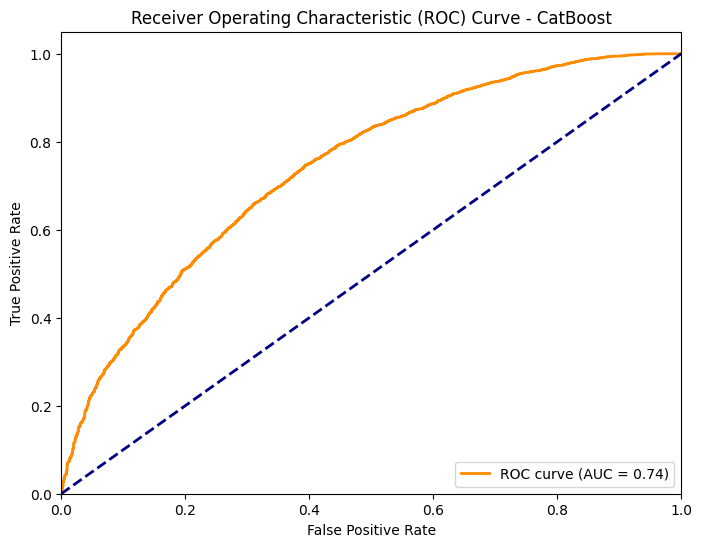

In [16]:
y_pred = Cat_model.predict(X_test)
y_prob = Cat_model.predict_proba(X_test)[:,1]

# brier score 
test_brier_score = custom_brier_score(y_test, y_prob)
print(f"Test Brier Score: {test_brier_score:.4f}")

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - CatBoost')
plt.legend(loc='lower right')
plt.show()


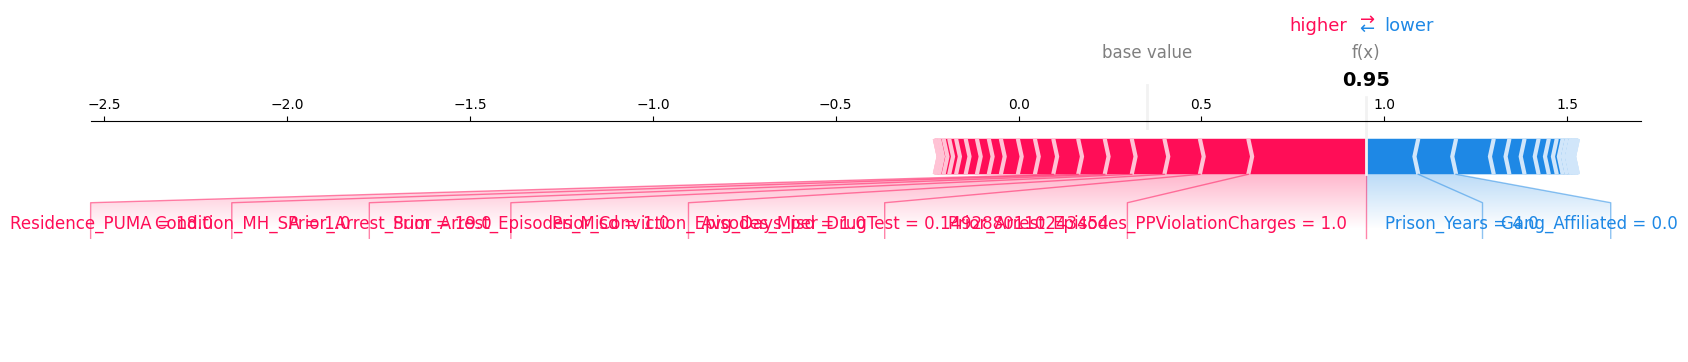

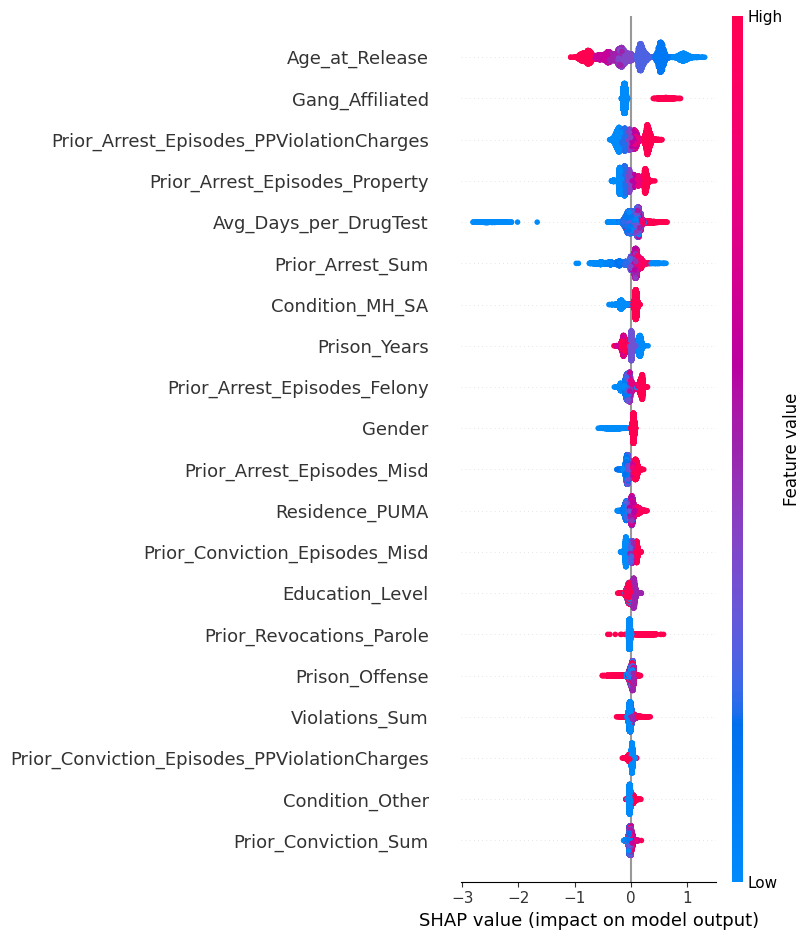

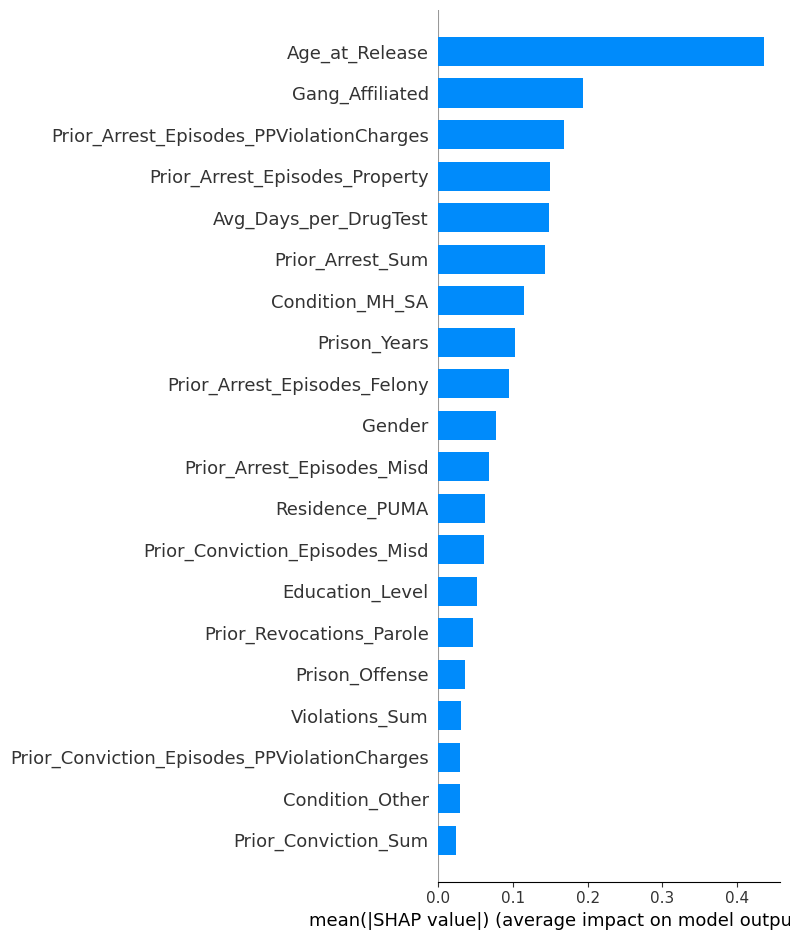

In [52]:
# USing SHAP for feature importance 
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(Cat_model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], matplotlib=True)

# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

# summarize the effects of all the features
shap.summary_plot(shap_values, X_train, plot_type="bar")


In [23]:
# Take to long to run 
"""

# visualize the training set predictions
# this plot gives insight on the distribution of the SHAP values for each feature and for each prediction 
shap.force_plot(explainer.expected_value, shap_values, X_train)


# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train, link="logit")


# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Age_at_Release", shap_values, X_train)

# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Prior_Arrest_Episodes_Felony", shap_values, X_train)

# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Prior_Arrest_Episodes_Misdemeanor", shap_values, X_train)

"""


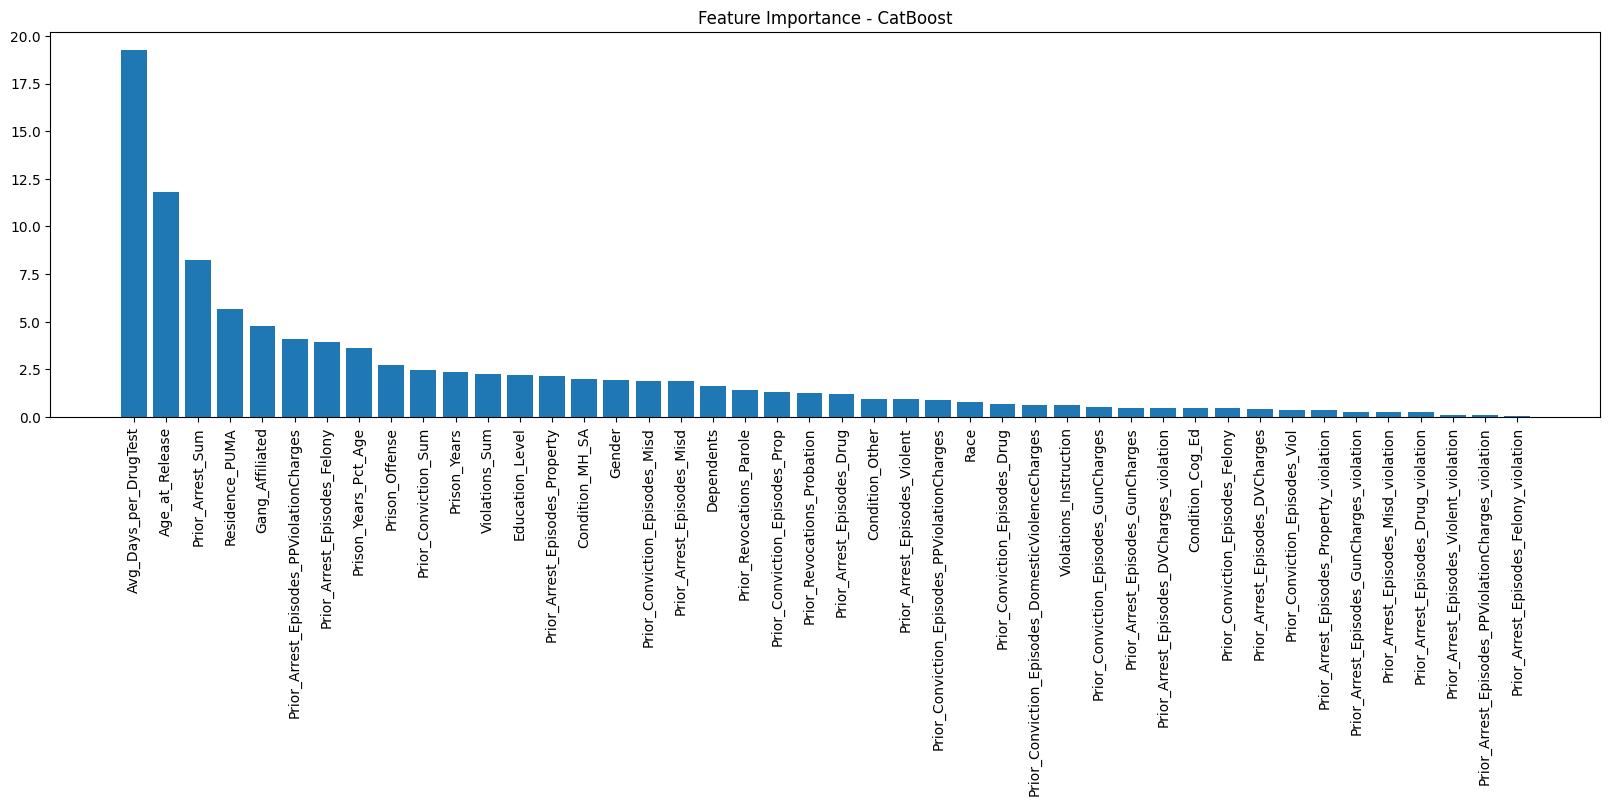

Avg_Days_per_DrugTest         : 1924.64%
Age_at_Release                : 1181.88%
Prior_Arrest_Sum              : 824.29%
Residence_PUMA                : 565.77%
Gang_Affiliated               : 476.94%
Prior_Arrest_Episodes_PPViolationCharges: 410.15%
Prior_Arrest_Episodes_Felony  : 392.18%
Prison_Years_Pct_Age          : 361.57%
Prison_Offense                : 269.89%
Prior_Conviction_Sum          : 247.73%
Prison_Years                  : 234.44%
Violations_Sum                : 224.73%
Education_Level               : 221.35%
Prior_Arrest_Episodes_Property: 212.37%
Condition_MH_SA               : 198.42%
Gender                        : 192.98%
Prior_Conviction_Episodes_Misd: 190.50%
Prior_Arrest_Episodes_Misd    : 189.56%
Dependents                    : 163.16%
Prior_Revocations_Parole      : 139.87%
Prior_Conviction_Episodes_Prop: 128.10%
Prior_Revocations_Probation   : 126.49%
Prior_Arrest_Episodes_Drug    : 118.22%
Condition_Other               : 95.41%
Prior_Arrest_Episodes_Violent

In [44]:
# important feats analysis: 
# Get feature importances: default is 'PredictionValuesChange'
feature_importances = Cat_model.get_feature_importance()
# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20, 5))

# Create plot title
plt.title(f"Feature Importance - CatBoost")

# Add bars
plt.bar(range(X_train.shape[1]), feature_importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

# Print feature importance - top 10
for name, importance in zip(names, feature_importances[indices]):
    print(f"{name:<30}: {importance:>6.2%}")


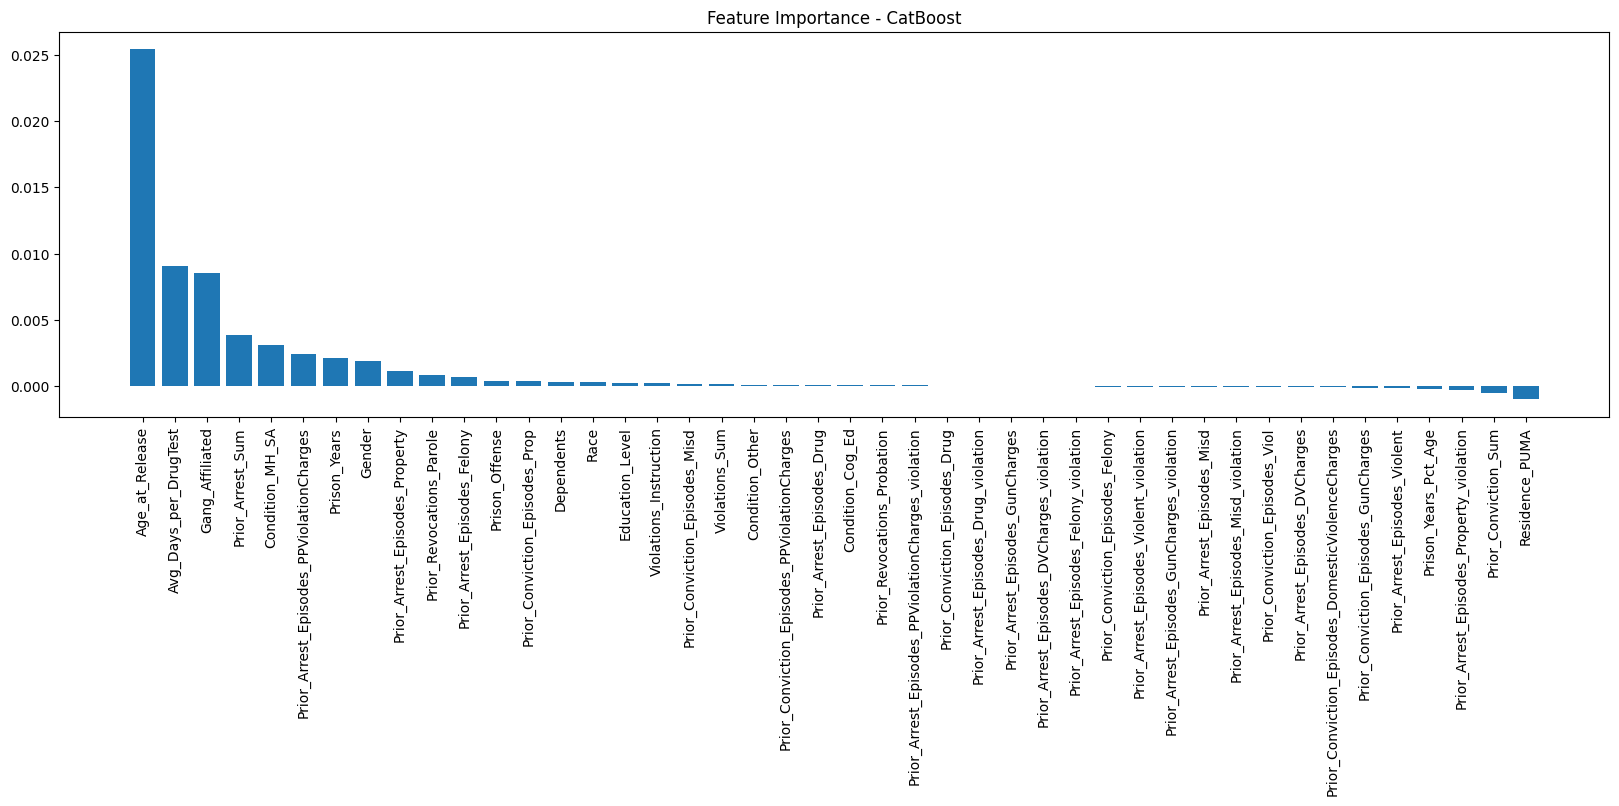

Age_at_Release                :  2.54%
Avg_Days_per_DrugTest         :  0.91%
Gang_Affiliated               :  0.85%
Prior_Arrest_Sum              :  0.38%
Condition_MH_SA               :  0.31%
Prior_Arrest_Episodes_PPViolationCharges:  0.25%
Prison_Years                  :  0.21%
Gender                        :  0.19%
Prior_Arrest_Episodes_Property:  0.12%
Prior_Revocations_Parole      :  0.09%
Prior_Arrest_Episodes_Felony  :  0.07%
Prison_Offense                :  0.04%
Prior_Conviction_Episodes_Prop:  0.04%
Dependents                    :  0.03%
Race                          :  0.03%
Education_Level               :  0.03%
Violations_Instruction        :  0.02%
Prior_Conviction_Episodes_Misd:  0.02%
Violations_Sum                :  0.02%
Condition_Other               :  0.01%
Prior_Conviction_Episodes_PPViolationCharges:  0.01%
Prior_Arrest_Episodes_Drug    :  0.01%
Condition_Cog_Ed              :  0.01%
Prior_Revocations_Probation   :  0.01%
Prior_Arrest_Episodes_PPViolationCharges

In [45]:
# using LossFunctionChange as feature importance type 
feature_importances_loss = Cat_model.get_feature_importance(type='LossFunctionChange', data=cb.Pool(X_test, label=y_test))

# Sort feature importances in descending order
indices = np.argsort(feature_importances_loss)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]


# Create plot
plt.figure(figsize=(20, 5))

# Create plot title
plt.title(f"Feature Importance - CatBoost")

# Add bars
plt.bar(range(X_train.shape[1]), feature_importances_loss[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

# Print feature importance - top 10
for name, importance in zip(names, feature_importances_loss[indices]):
    print(f"{name:<30}: {importance:>6.2%}")
    

